In [1]:
import pandas as pd

In [21]:
#uploading data needed
df = pd.read_parquet(r'/Users/apple/Desktop/parquets/allMoreThan200.parquet.gzip', 
                     columns=['owner_id', 'clean'])

len(df)

6426493

In [3]:
import artm


# creating the function for transformation to vowpal_wabbit format

def df_to_vw_regression(df, filepath='in.txt', columns=None, target=None, namespace='clean'):
    if columns is None:
        columns = df.columns.tolist()
    columns.remove(target)

    with open(filepath, 'w') as f:
        for _, row in tqdm(df.iterrows()):
            if namespace:
                f.write('|{0} '.format( namespace))
            else:
                f.write('{0} | '.format(row[target]))
            last_feature = row.index.values[-1]
            for idx, val in row.iteritems():
                if idx not in columns:
                    continue
                if isinstance(val, str):
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                elif isinstance(val, float) or isinstance(val, int):
                    if not math.isnan(val):
                        f.write('{0}:{1}'.format(idx.replace(' ', ' ').replace(':', ' '), val))
                    else:
                        continue
                else:
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                if idx != last_feature:
                    f.write(' ')
            f.write('\n')



In [4]:
from tqdm import tqdm
# changing the type of data created
vw = df_to_vw_regression(df, filepath='data_.txt', target='owner_id')

6426493it [13:53, 7707.17it/s]


In [5]:
del df, vw

In [6]:
locals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  'import pandas as pd',
  "#uploading data needed\ndf = pd.read_parquet(r'/Users/apple/Desktop/parquets/allMoreThan200.parquet.gzip', \n                     columns=['owner_id', 'clean'])\n\nlen(df)",
  "import artm\n\n\n# creating the function for transformation to vowpal_wabbit format\n\ndef df_to_vw_regression(df, filepath='in.txt', columns=None, target=None, namespace='clean'):\n    if columns is None:\n        columns = df.columns.tolist()\n    columns.remove(target)\n\n    with open(filepath, 'w') as f:\n        for _, row in tqdm(df.iterrows()):\n            if namespace:\n                f.write('|{0} '.format( namespace))\n            else:\n                f.write('{0} | '.format(row[target]))\n        

In [7]:

# batching data for applying it to our model
batch_vectorizer = artm.BatchVectorizer(data_path='data_.txt',
                                        data_format='vowpal_wabbit',
                                        collection_name='vw',
                                        target_folder='batchesND')

In [8]:
#batch_vectorizer = artm.BatchVectorizer(data_path='batchesND', data_format='batches')
# setting up dictionary
dictionary = batch_vectorizer.dictionary


In [9]:
number_of_topics = 70
topic_names = ['topic_{}'.format(i) for i in range(number_of_topics)]

# inial objects creation
model_artm = artm.ARTM(topic_names=topic_names,
                       cache_theta=True,
                       dictionary=dictionary, 
                       seed = 123,
                       show_progress_bars = True)

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary = dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
#model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='top_words',num_tokens = 10))

# additional regulizers
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+4))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparseTheta', tau=- 0.05))
#model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau= 0.3, topic_names= topic_names))#[35:]))

#setting up the number of tokens
model_artm.num_document_passes = 10

#initializing the model we've set up
model_artm.initialize(dictionary=dictionary)

In [10]:
# fitting the model
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=17)

Pass:   0%|          | 0/17 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

Batch:   0%|          | 0/6427 [00:00<?, ?it/s]

In [11]:
# phi and theta
#artm_phi = model_artm.get_phi()
## top_tokens
top_tokens = model_artm.score_tracker['top_words']
for topic_name in model_artm.topic_names:
    print ('\n',topic_name)
    for (token, weight) in zip(top_tokens.last_tokens[topic_name][:number_of_topics],top_tokens.last_weights[topic_name][:number_of_topics]):
        print (token, '-', weight)


 topic_0
лук - 0.010948698967695236
перец - 0.010448900982737541
соль - 0.007927506230771542
сыр - 0.00739118829369545
салат - 0.006683656480163336
вкусу - 0.006294824182987213
мясо - 0.006136254873126745
чеснок - 0.005562339909374714
морковь - 0.005305927712470293
ингредиенты - 0.005272123031318188

 topic_1
права - 0.005135956220328808
право - 0.0050493632443249226
года - 0.0048954300582408905
случае - 0.004888053983449936
также - 0.004584293346852064
суд - 0.0035353435669094324
федерации - 0.0032592860516160727
прав - 0.003215209348127246
закон - 0.0028278143145143986
граждан - 0.0028126537799835205

 topic_2
тела - 0.010215711779892445
энергии - 0.009786115027964115
тело - 0.009544272907078266
это - 0.008204900659620762
состояние - 0.007624450139701366
массаж - 0.007559183053672314
человека - 0.007364633027464151
практики - 0.0059383586049079895
здоровье - 0.005448139272630215
энергия - 0.005229361820966005

 topic_3
очень - 0.01873174123466015
нужно - 0.01603182777762413
пожалуйс

санкт - 0.03562900796532631
петербург - 0.018118856474757195
мая - 0.01789512299001217
января - 0.017625730484724045
петербурге - 0.011731461621820927
петербурга - 0.011558388359844685
фестиваль - 0.01099926047027111
билеты - 0.009044026024639606
декабря - 0.009017125703394413
июня - 0.00852042343467474

 topic_31
это - 0.006356684025377035
сказал - 0.005769964773207903
сказала - 0.0031349603086709976
домой - 0.0029226653277873993
говорит - 0.0026594975497573614
мама - 0.0023961185943335295
дверь - 0.0022359120193868876
дома - 0.0021894497331231833
глаза - 0.0021426824387162924
стал - 0.0020997640676796436

 topic_32
животных - 0.015277372673153877
собак - 0.009114635176956654
собаки - 0.008928964845836163
собака - 0.007134588435292244
зубов - 0.006066136993467808
кот - 0.00574667239561677
зубы - 0.005619720555841923
кошек - 0.004927078261971474
животные - 0.0049215881153941154
кошки - 0.004907654132694006

 topic_33
сто - 0.011564447544515133
ник - 0.0051312875002622604
ста - 0.004884

жизни - 0.02973819710314274
жизнь - 0.014431793242692947
пусть - 0.0096468860283494
друг - 0.009105565026402473
любви - 0.00787574052810669
день - 0.0076377796940505505
новым - 0.007595110218971968
счастье - 0.007471150252968073
своей - 0.007356191519647837
счастья - 0.007333178073167801

 topic_58
это - 0.03855309262871742
всё - 0.03023354709148407
люди - 0.01628575474023819
ещё - 0.011877665296196938
жизнь - 0.011263640597462654
просто - 0.007185585331171751
жизни - 0.007040743716061115
делать - 0.0067102862522006035
раньше - 0.005744642112404108
кажется - 0.005577330011874437

 topic_59
организма - 0.0057982890866696835
также - 0.0057349554263055325
организм - 0.005324757192283869
веществ - 0.004645659122616053
крови - 0.003877987852320075
это - 0.0037341259885579348
которые - 0.0035753834526985884
питания - 0.003233775030821562
воды - 0.003127554664388299
количество - 0.0030259264167398214

 topic_60
кино - 0.009074981324374676
фильм - 0.009010476060211658
искусства - 0.00751602975

In [12]:
perplexityScore = list(model_artm.score_tracker['PerplexityScore'].value)
perplexityScore[1:]

[47236.6015625,
 38604.95703125,
 27780.685546875,
 21591.4765625,
 18606.962890625,
 16986.693359375,
 16021.654296875,
 15401.658203125,
 14979.1376953125,
 14679.3193359375,
 14460.9384765625,
 14296.8232421875,
 14170.1533203125,
 14069.4892578125,
 13987.7177734375,
 13919.7177734375]

/Users/apple/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  from PIL import PILLOW_VERSION


Text(0, 0.5, 'perplexity score')

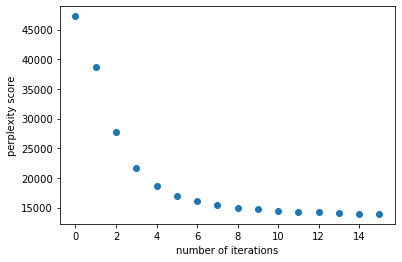

In [13]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

# visualizing perplexity [1:]
plt.scatter(range(len(perplexityScore[1:])), perplexityScore[1:])
plt.xlabel('number of iterations')
plt.ylabel('perplexity score')

Text(0, 0.5, 'perplexity score')

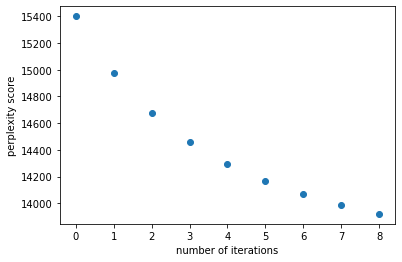

In [14]:
plt.scatter(range(len(perplexityScore[8:])), perplexityScore[8:])
plt.xlabel('number of iterations')
plt.ylabel('perplexity score')

In [15]:

artm_theta1 = model_artm.get_theta(topic_names = topic_names[:35])
artm_theta2 = model_artm.get_theta(topic_names = topic_names[35:])

artm_theta = pd.concat([artm_theta1, artm_theta2], axis = 0)

In [16]:
artm_theta

6058000       6058001       6058002       6058003  \
topic_0   0.000000e+00  6.541720e-04  4.441986e-15  1.129546e-16   
topic_1   2.146855e-01  8.751345e-02  8.088738e-02  2.465642e-01   
topic_2   7.640929e-08  7.351242e-03  1.727851e-02  3.967231e-09   
topic_3   2.443643e-05  1.004154e-03  2.471958e-02  3.177771e-02   
topic_4   3.103215e-10  9.183386e-05  6.874419e-04  1.676095e-07   
topic_5   7.128885e-06  6.176202e-09  7.245524e-03  4.870365e-09   
topic_6   1.217568e-06  1.471825e-04  8.487371e-08  5.120677e-09   
topic_7   2.833351e-02  1.788652e-04  4.432108e-07  9.491445e-14   
topic_8   3.903184e-09  1.026653e-04  3.354149e-03  1.193482e-03   
topic_9   4.368806e-12  7.854591e-03  4.329064e-07  8.316068e-11   
topic_10  1.386835e-01  8.097122e-02  4.138867e-04  4.571712e-06   
topic_11  2.167822e-10  2.146120e-01  1.160840e-01  2.794386e-01   
topic_12  1.505467e-06  3.715162e-08  5.481633e-10  5.761836e-08   
topic_13  1.337477e-08  3.719489e-09  2.909892e-11  1.299033e-03   
topic_14  3.805019e-01  2.226049e-16  3.924595e-11  6.944799e-12   
topic_15  9.386774e-09  1.902860e-05  1.142829e-04  5.079525e-02   
topic_16  2.819070e-13  3.973602e-15  2.058497e-16  6.703300e-15   
topic_17  0.000000e+00  2.583577e-04  3.404939e-05  2.535036e-06   
topic_18  8.706700e-06  1.127946e-05  1.558557e-12  4.916229e-08   
topic_19  3.229876e-02  2.271077e-05  9.844297e-06  9.564581e-06   
topic_20  2.805679e-06  4.103386e-02  2.033402e-03  2.332887e-07   
topic_21  1.159060e-16  3.180984e-12  1.324094e-12  5.378644e-11   
topic_22  0.000000e+00  1.441166e-11  4.490693e-02  1.786480e-06   
topic_23  8.629930e-10  5.988601e-08  4.147177e-11  2.308299e-11   
topic_24  8.156210e-14  1.395548e-12  2.267898e-11  4.675225e-11   
topic_25  0.000000e+00  7.404615e-05  1.017941e-04  2.965419e-08   
topic_26  2.217030e-10  4.719543e-09  3.485374e-13  3.134353e-06   
topic_27  1.224845e-05  1.489462e-01  2.620713e-03  1.510158e-04   
topic_28  3.150960e-14  7.097580e-05  1.820689e-01  2.844320e-03   
topic_29  2.703637e-04  6.726853e-05  6.047361e-06  9.535705e-06   
...                ...           ...           ...           ...   
topic_40  1.448649e-07  1.449579e-08  1.875222e-02  1.833639e-06   
topic_41  5.883532e-11  1.941710e-02  2.118248e-02  3.272739e-07   
topic_42  2.034524e-02  5.066323e-06  3.418955e-03  6.753571e-03   
topic_43  8.284444e-14  4.761680e-12  4.488852e-03  1.770013e-16   
topic_44  4.763964e-03  5.112645e-07  4.304143e-03  2.658903e-10   
topic_45  0.000000e+00  3.350125e-02  3.922968e-11  1.630074e-16   
topic_46  3.750899e-13  9.013576e-11  3.415071e-16  0.000000e+00   
topic_47  1.970287e-11  1.016163e-09  6.041314e-06  7.751334e-02   
topic_48  4.854531e-03  4.222678e-04  2.188940e-10  6.191260e-05   
topic_49  4.800983e-04  1.439970e-02  2.586754e-07  8.247904e-03   
topic_50  8.731593e-09  9.283720e-14  0.000000e+00  0.000000e+00   
topic_51  8.444960e-02  1.230438e-02  8.788697e-06  4.022369e-12   
topic_52  0.000000e+00  7.840556e-03  2.390176e-14  3.589269e-04   
topic_53  2.378215e-14  1.904561e-04  6.018853e-09  1.519034e-03   
topic_54  1.715374e-07  1.573649e-02  2.798453e-03  1.400120e-04   
topic_55  1.788633e-03  1.684257e-01  1.344930e-01  1.999281e-01   
topic_56  2.213992e-15  3.153305e-06  5.295393e-09  2.142220e-16   
topic_57  8.593458e-06  2.073672e-07  1.044655e-10  3.159439e-05   
topic_58  5.535221e-04  1.030283e-04  1.127864e-03  8.146468e-04   
topic_59  2.784734e-06  2.703583e-06  1.551324e-06  1.574881e-07   
topic_60  2.528429e-11  4.577287e-07  7.421211e-10  1.547371e-11   
topic_61  1.547157e-08  3.608027e-03  2.069186e-05  1.052523e-03   
topic_62  1.525224e-07  1.339978e-02  7.044744e-07  4.879721e-09   
topic_63  3.304635e-15  1.003678e-05  8.139275e-09  2.461129e-05   
topic_64  0.000000e+00  1.644735e-05  1.690974e-02  1.746230e-02   
topic_65  2.241706e-11  3.607390e-03  2.393897e-04  0.000000e+00   
topic_66  2.896596e-15  5.127995e-06  0.000000e+00  2.362410e-10   
top

In [17]:
import re
from pymystem3 import Mystem
lables = dict()
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

item='expand'
w = 'text'
# lemmatisation of top tokens

for topic_name in model_artm.topic_names:
    
    lables[topic_name] = ' '.join(word for word in top_tokens.last_tokens[topic_name][0:6])
    lables[topic_name] = ''.join(Mystem().lemmatize(lables[topic_name]))
    lables[topic_name] = ' '.join(unique_list(lables[topic_name].split()))
    lables[topic_name] = re.sub(r'\b%s\b' % w, '', lables[topic_name])
    lables[topic_name] = re.sub(r'\b%s\b' % item, '', lables[topic_name])
    print(lables[topic_name])
    
    artm_theta.rename({topic_name:lables[topic_name]}, inplace = True)

    
lables

лук перец соль сыр салат вкус
право год случай также суд
тело энергия этот состояние массаж
очень нужно пожалуйста кто деньги хотеть
игра команда
цветок стиль дизайн украшение
цена доставка заказ наличие набор
друг участие участник приглашать дорогой ждать
сердце лишь любовь снова это глаз
ребенок год родитель
сайт интернет сеть проект
война область ссср район россия город
мышца тренировка упражнение вес рука
мастер бровь краска ноготь рисунок форма
одежда размер платье обувь ткань
iphone часы apple устройство телефон
время информация наш кроме сам цель
работа опыт работать год
музыка группа концерт песня
рубль стоимость тыс услуга область
___ ____ вконтакте _____ ссылка instagram
вкус кофе меню кафе продукт блюдо
цвет белый черный красный глаз
школа обучение тема язык
масло вода минута кофе
лето зима солнце снег весна
кожа волос лицо
слово пора против это сей
век церковь храм день город
человек который это мочь быть ваш
санкт петербург май январь
это сказать домой говорить мама
животн

{'topic_0': 'лук перец соль сыр салат вкус',
 'topic_1': 'право год случай также суд',
 'topic_2': 'тело энергия этот состояние массаж',
 'topic_3': 'очень нужно пожалуйста кто деньги хотеть',
 'topic_4': 'игра команда',
 'topic_5': 'цветок стиль дизайн украшение',
 'topic_6': 'цена доставка заказ наличие набор',
 'topic_7': 'друг участие участник приглашать дорогой ждать',
 'topic_8': 'сердце лишь любовь снова это глаз',
 'topic_9': 'ребенок год родитель',
 'topic_10': 'сайт интернет сеть проект',
 'topic_11': 'война область ссср район россия город',
 'topic_12': 'мышца тренировка упражнение вес рука',
 'topic_13': 'мастер бровь краска ноготь рисунок форма',
 'topic_14': 'одежда размер платье обувь ткань',
 'topic_15': 'iphone часы apple устройство телефон',
 'topic_16': 'время информация наш кроме сам цель',
 'topic_17': 'работа опыт работать год',
 'topic_18': 'музыка группа концерт песня',
 'topic_19': 'рубль стоимость тыс услуга область',
 'topic_20': '___ ____ вконтакте _____ ссы

In [18]:
artm_theta.head()

6058000   6058001  \
лук перец соль сыр салат вкус             0.000000e+00  0.000654   
право год случай также суд                2.146855e-01  0.087513   
тело энергия этот состояние массаж        7.640929e-08  0.007351   
очень нужно пожалуйста кто деньги хотеть  2.443643e-05  0.001004   
игра команда                              3.103215e-10  0.000092   

                                               6058002       6058003  \
лук перец соль сыр салат вкус             4.441986e-15  1.129546e-16   
право год случай также суд                8.088738e-02  2.465642e-01   
тело энергия этот состояние массаж        1.727851e-02  3.967231e-09   
очень нужно пожалуйста кто деньги хотеть  2.471958e-02  3.177771e-02   
игра команда                              6.874419e-04  1.676095e-07   

                                               6058004       6058005  \
лук перец соль сыр салат вкус             8.319775e-10  7.622073e-15   
право год случай также суд                1.093818e-08  2.201599e-03   
тело энергия этот состояние массаж        6.875386e-11  5.707877e-03   
очень нужно пожалуйста кто деньги хотеть  0.000000e+00  1.485238e-02   
игра команда                              5.576937e-08  1.581127e-05   

                                               6058006       6058007  \
лук перец соль сыр салат вкус             3.324481e-16  0.000000e+00   
право год случай также суд                1.270417e-11  1.465656e-07   
тело энергия этот состояние массаж        8.005865e-08  2.243116e-10   
очень нужно пожалуйста кто деньги хотеть  3.794113e-10  2.486950e-05   
игра команда                              1.736236e-10  8.721576e-10   

                                               6058008       6058009  ...  \
лук перец соль сыр салат вкус             0.000000e+00  4.437392e-15  ...   
право год случай также суд                1.557293e-15  1.094846e-10  ...   
тело энергия этот состояние массаж        1.650565e-10  6.589323e-06  ...   
очень нужно пожалуйста кто деньги хотеть  0.000000e+00  3.284113e-10  ...   
игра команда                              1.118473e-10  1.400366e-12  ...   

                                               3249990       3249991  \
лук перец соль сыр салат вкус             2.757823e-04  1.290170e-08   
право год случай также суд                2.419286e-06  1.841374e-03   
тело энергия этот состояние массаж        3.165656e-03  4.976892e-04   
очень нужно пожалуйста кто деньги хотеть  6.257918e-07  1.548194e-14   
игра команда                              3.309942e-06  1.523680e-12   

                                               3249992       3249993  \
лук перец соль сыр салат вкус             1.034161e-15  0.000000e+00   
право год случай также суд                5.705814e-07  2.592889e-14   
тело энергия этот состояние массаж        9.279065e-03  0.000000e+00   
очень нужно пожалуйста кто деньги хотеть  2.862862e-02  7.600810e-07   
игра команда                              1.346230e-10  1.520515e-09   

                                               3249994       3249995  \
лук перец соль сыр салат вкус             0.000000e+00  2.323170e-12   
право год случай также суд                8.990511e-12  1.522629e-02   
тело энергия этот состояние массаж        1.283126e-16  1.031805e-05   
очень нужно пожалуйста кто деньги хотеть  1.195352e-11  4.993733e-02   
игра команда                              2.065100e-01  2.364013e-07   

                                               3249996       3249997  \
лук перец соль сыр салат вкус             0.000000e+00  0.000000e+00   
право год случай также суд                6.487230e-05  3.747047e-05   
тело энергия этот состояние массаж        1.759740e-04  1.388780e-08   
очень нужно пожалуйста кто деньги хотеть  8.562819e-11  9.866148e-04   
игра команда                              3.139142e-08  2.400354e-07   

                                               3249998       3249999  
лук перец соль сыр салат вкус             4.954024e-12  0.000000e+00  
пр

In [19]:
theta_transposed = artm_theta.transpose()
theta_transposed

лук перец соль сыр салат вкус  право год случай также суд  \
6058000                   0.000000e+00                2.146855e-01   
6058001                   6.541720e-04                8.751345e-02   
6058002                   4.441986e-15                8.088738e-02   
6058003                   1.129546e-16                2.465642e-01   
6058004                   8.319775e-10                1.093818e-08   
6058005                   7.622073e-15                2.201599e-03   
6058006                   3.324481e-16                1.270417e-11   
6058007                   0.000000e+00                1.465656e-07   
6058008                   0.000000e+00                1.557293e-15   
6058009                   4.437392e-15                1.094846e-10   
6058010                   2.208660e-13                1.872976e-05   
6058011                   2.021513e-16                1.157140e-04   
6058012                   0.000000e+00                3.647436e-07   
6058013                   0.000000e+00                1.108284e-02   
6058014                   2.161932e-13                2.046699e-05   
6058015                   3.900354e-09                2.231064e-04   
6058016                   0.000000e+00                1.773816e-05   
6058017                   9.673897e-02                8.960557e-05   
6058018                   1.022601e-12                4.177242e-03   
6058019                   2.140107e-13                1.611481e-03   
6058020                   0.000000e+00                5.185225e-03   
6058021                   0.000000e+00                3.246400e-06   
6058022                   3.606688e-15                3.248425e-15   
6058023                   0.000000e+00                0.000000e+00   
6058024                   0.000000e+00                2.540052e-05   
6058025                   3.036069e-16                1.186293e-10   
6058026                   2.988275e-16                1.255191e-10   
6058027                   1.498400e-14                3.786610e-10   
6058028                   1.565329e-14                9.747017e-09   
6058029                   9.093831e-15                2.476261e-02   
...                                ...                         ...   
3249970                   1.833929e-02                1.949710e-12   
3249971                   0.000000e+00                8.312134e-16   
3249972                   1.311539e-16                2.294993e-05   
3249973                   0.000000e+00                7.733378e-14   
3249974                   0.000000e+00                1.519033e-02   
3249975                   0.000000e+00                9.583697e-10   
3249976                   0.000000e+00                3.885234e-11   
3249977                   1.823773e-09                1.081796e-09   
3249978                   1.925493e-14                1.439108e-05   
3249979                   0.000000e+00                2.425407e-04   
3249980                   0.000000e+00                1.438080e-15   
3249981                   1.707749e-10                4.063800e-10   
3249982                   3.327829e-03                0.000000e+00   
3249983                   6.918730e-12                4.635776e-06   
3249984                   8.586638e-16                5.441685e-13   
3249985                   3.368662e-09                0.000000e+00   
3249986                   5.956325e-08                3.278164e-12   
3249987                   0.000000e+00                1.551876e-09   
3249988                   0.000000e+00                4.661551e-10   
3249989                   0.000000e+00                0.000000e+00   
3249990                   2.757823e-04                2.419286e-06   
3249991                   1.290170e-08                1.841374e-03   
3249992                   1.034161e-15                5.705814e-07   
3249993                   0.000000e+00                2.592889e-14   
3249994                   0.000000e+00                8.990511e-12   
3249995            

In [22]:
theta_transposed['owner_id'] = df['owner_id']
theta_transposed['text'] = df['clean']
theta_transposed

лук перец соль сыр салат вкус  право год случай также суд  \
6058000                   0.000000e+00                2.146855e-01   
6058001                   6.541720e-04                8.751345e-02   
6058002                   4.441986e-15                8.088738e-02   
6058003                   1.129546e-16                2.465642e-01   
6058004                   8.319775e-10                1.093818e-08   
6058005                   7.622073e-15                2.201599e-03   
6058006                   3.324481e-16                1.270417e-11   
6058007                   0.000000e+00                1.465656e-07   
6058008                   0.000000e+00                1.557293e-15   
6058009                   4.437392e-15                1.094846e-10   
6058010                   2.208660e-13                1.872976e-05   
6058011                   2.021513e-16                1.157140e-04   
6058012                   0.000000e+00                3.647436e-07   
6058013                   0.000000e+00                1.108284e-02   
6058014                   2.161932e-13                2.046699e-05   
6058015                   3.900354e-09                2.231064e-04   
6058016                   0.000000e+00                1.773816e-05   
6058017                   9.673897e-02                8.960557e-05   
6058018                   1.022601e-12                4.177242e-03   
6058019                   2.140107e-13                1.611481e-03   
6058020                   0.000000e+00                5.185225e-03   
6058021                   0.000000e+00                3.246400e-06   
6058022                   3.606688e-15                3.248425e-15   
6058023                   0.000000e+00                0.000000e+00   
6058024                   0.000000e+00                2.540052e-05   
6058025                   3.036069e-16                1.186293e-10   
6058026                   2.988275e-16                1.255191e-10   
6058027                   1.498400e-14                3.786610e-10   
6058028                   1.565329e-14                9.747017e-09   
6058029                   9.093831e-15                2.476261e-02   
...                                ...                         ...   
3249970                   1.833929e-02                1.949710e-12   
3249971                   0.000000e+00                8.312134e-16   
3249972                   1.311539e-16                2.294993e-05   
3249973                   0.000000e+00                7.733378e-14   
3249974                   0.000000e+00                1.519033e-02   
3249975                   0.000000e+00                9.583697e-10   
3249976                   0.000000e+00                3.885234e-11   
3249977                   1.823773e-09                1.081796e-09   
3249978                   1.925493e-14                1.439108e-05   
3249979                   0.000000e+00                2.425407e-04   
3249980                   0.000000e+00                1.438080e-15   
3249981                   1.707749e-10                4.063800e-10   
3249982                   3.327829e-03                0.000000e+00   
3249983                   6.918730e-12                4.635776e-06   
3249984                   8.586638e-16                5.441685e-13   
3249985                   3.368662e-09                0.000000e+00   
3249986                   5.956325e-08                3.278164e-12   
3249987                   0.000000e+00                1.551876e-09   
3249988                   0.000000e+00                4.661551e-10   
3249989                   0.000000e+00                0.000000e+00   
3249990                   2.757823e-04                2.419286e-06   
3249991                   1.290170e-08                1.841374e-03   
3249992                   1.034161e-15                5.705814e-07   
3249993                   0.000000e+00                2.592889e-14   
3249994                   0.000000e+00                8.990511e-12   
3249995            

In [23]:

odd_themes = [
    
  'очень нужно пожалуйста кто деньги хотеть',
  'друг участие участник приглашать дорогой ждать',
  'сердце лишь любовь снова это глаз',
  'время информация наш кроме сам цель',
  '___ ____ вконтакте _____ ссылка instagram',
  'цвет белый черный красный глаз',
  'лето зима солнце снег весна',
  'слово пора против это сей',
  'человек который это мочь быть ваш',
  'санкт петербург май январь',
  'это сказать домой говорить мама',
  'сто ник лена катя кто',
  'мир это жизнь бог человек',
  'это просто поэтому именно очень стоять',
  'женщина мужчина',
  'мир самый это благодаря являться вид',
  'мочь сайт наш бесплатно цена',
  'день праздник новый шоу рождение год',
  'ты видео самый главное хотеть это',
  'nbsp александр сергей андрей дмитрий елена',
  'the amp and you for mix',
  'являться который человек образ также мочь',
  'руб стоимость чай грн чело ночь',
  'com запись репост конкурс группа',
  'москва область салон казань россия екатеринбург',
  'минута затем шаг форма ряд далее',
  'часто проблема мочь день время нужно',
  'мастер занятие курс класс запись',
  'жизнь пусть друг любовь день',
  'это все человек еще жизнь просто',
  'организм также вещество кровь это',
  'россия страна развитие также мир',
  'очень спасибо хотеть быть мой мочь',
  'рука движение нога сторона вперед',
  'писать звонить вопрос whatsapp сообщение viber',
  'спб студия питер красота',
  'год становиться который',
  'все сегодня привет день пока завтра']



theta_transposed.drop(odd_themes,axis = 1, inplace = True)
theta_transposed


лук перец соль сыр салат вкус  право год случай также суд  \
6058000                   0.000000e+00                2.146855e-01   
6058001                   6.541720e-04                8.751345e-02   
6058002                   4.441986e-15                8.088738e-02   
6058003                   1.129546e-16                2.465642e-01   
6058004                   8.319775e-10                1.093818e-08   
6058005                   7.622073e-15                2.201599e-03   
6058006                   3.324481e-16                1.270417e-11   
6058007                   0.000000e+00                1.465656e-07   
6058008                   0.000000e+00                1.557293e-15   
6058009                   4.437392e-15                1.094846e-10   
6058010                   2.208660e-13                1.872976e-05   
6058011                   2.021513e-16                1.157140e-04   
6058012                   0.000000e+00                3.647436e-07   
6058013                   0.000000e+00                1.108284e-02   
6058014                   2.161932e-13                2.046699e-05   
6058015                   3.900354e-09                2.231064e-04   
6058016                   0.000000e+00                1.773816e-05   
6058017                   9.673897e-02                8.960557e-05   
6058018                   1.022601e-12                4.177242e-03   
6058019                   2.140107e-13                1.611481e-03   
6058020                   0.000000e+00                5.185225e-03   
6058021                   0.000000e+00                3.246400e-06   
6058022                   3.606688e-15                3.248425e-15   
6058023                   0.000000e+00                0.000000e+00   
6058024                   0.000000e+00                2.540052e-05   
6058025                   3.036069e-16                1.186293e-10   
6058026                   2.988275e-16                1.255191e-10   
6058027                   1.498400e-14                3.786610e-10   
6058028                   1.565329e-14                9.747017e-09   
6058029                   9.093831e-15                2.476261e-02   
...                                ...                         ...   
3249970                   1.833929e-02                1.949710e-12   
3249971                   0.000000e+00                8.312134e-16   
3249972                   1.311539e-16                2.294993e-05   
3249973                   0.000000e+00                7.733378e-14   
3249974                   0.000000e+00                1.519033e-02   
3249975                   0.000000e+00                9.583697e-10   
3249976                   0.000000e+00                3.885234e-11   
3249977                   1.823773e-09                1.081796e-09   
3249978                   1.925493e-14                1.439108e-05   
3249979                   0.000000e+00                2.425407e-04   
3249980                   0.000000e+00                1.438080e-15   
3249981                   1.707749e-10                4.063800e-10   
3249982                   3.327829e-03                0.000000e+00   
3249983                   6.918730e-12                4.635776e-06   
3249984                   8.586638e-16                5.441685e-13   
3249985                   3.368662e-09                0.000000e+00   
3249986                   5.956325e-08                3.278164e-12   
3249987                   0.000000e+00                1.551876e-09   
3249988                   0.000000e+00                4.661551e-10   
3249989                   0.000000e+00                0.000000e+00   
3249990                   2.757823e-04                2.419286e-06   
3249991                   1.290170e-08                1.841374e-03   
3249992                   1.034161e-15                5.705814e-07   
3249993                   0.000000e+00                2.592889e-14   
3249994                   0.000000e+00                8.990511e-12   
3249995            

In [24]:
theta_transposed.to_parquet('theta_transposed_ND_big_clean.parquet.gzip',compression='gzip') 

In [1]:
import pandas as pd
!ls
theta_transposed = pd.read_parquet(r'theta_transposed_ND.parquet.gzip')

README.md
batches2
batchesND
bigartm.INFO
bigartm.WARNING
bigartm.as-MacBook-Pro.local.apple.log.INFO.20210227-233548.13112
bigartm.as-MacBook-Pro.local.apple.log.WARNING.20210228-121614.13112
data_.txt
data_df.txt
id-psy_posts.json
my_collection_batches
my_collection_batches_groups
myfile.txt
ra.py
run_artm-ND.ipynb
run_artm-ND_big.ipynb
run_artm-ND_small.ipynb
run_artm.ipynb
summarizer
text_generation_testing.ipynb
theta_transposed.csv
theta_transposed_ND.parquet.gzip
topic_modeling  copy.py
topic_modeling .py
tr_theta.csv


In [35]:
theta_transposed['owner_id'] = theta_transposed.owner_id.abs()
theta_transposed

игра команда  цветок стиль образ дизайн  \
2707000  6.794241e-03               2.940582e-03   
2707001  4.468788e-07               3.437737e-15   
2707002  9.764662e-09               8.009186e-03   
2707003  1.276337e-06               6.335764e-03   
2707004  8.277064e-15               1.889393e-09   
2707005  1.594461e-09               3.832289e-04   
2707006  3.246295e-15               0.000000e+00   
2707007  1.314770e-10               5.730792e-06   
2707008  2.621509e-07               3.108397e-07   
2707009  9.388572e-12               1.068671e-11   
2707010  3.934928e-06               1.414006e-08   
2707011  3.185076e-11               3.662137e-12   
2707012  1.724101e-05               2.592146e-02   
2707013  5.471642e-08               2.690028e-07   
2707014  6.040242e-12               7.320063e-13   
2707015  3.512501e-03               3.220749e-04   
2707016  4.381007e-10               6.054712e-08   
2707017  1.065263e-07               9.280727e-03   
2707018  4.439008e-14               5.041974e-13   
2707019  8.615666e-14               4.429650e-13   
2707020  2.331820e-03               5.791975e-10   
2707021  2.498480e-16               2.224097e-03   
2707022  3.883593e-14               8.083620e-12   
2707023  3.415574e-04               6.128518e-02   
2707024  6.579613e-06               1.088241e-12   
2707025  1.548626e-09               1.263066e-04   
2707026  0.000000e+00               1.183098e-04   
2707027  1.401469e-08               4.969846e-07   
2707028  4.092881e-07               2.323867e-03   
2707029  1.046974e-09               4.355727e-14   
...               ...                        ...   
1011970  8.622803e-04               7.611615e-09   
1011971  1.555255e-08               3.209131e-03   
1011972  5.868900e-10               1.513261e-16   
1011973  3.410235e-02               1.362833e-16   
1011974  3.001231e-02               1.558158e-12   
1011975  3.304573e-05               4.618152e-10   
1011976  1.089243e-05               1.492460e-03   
1011977  2.403216e-04               6.458913e-09   
1011978  2.164826e-07               1.257256e-08   
1011979  0.000000e+00               5.667915e-02   
1011980  5.100127e-06               2.852402e-02   
1011981  1.286995e-02               4.490230e-02   
1011982  9.399961e-16               1.153573e-01   
1011983  7.442538e-14               7.768179e-02   
1011984  3.610952e-14               1.410425e-07   
1011985  2.634882e-13               6.800925e-03   
1011986  2.591112e-02               4.346895e-02   
1011987  7.052177e-15               8.476075e-06   
1011988  0.000000e+00               0.000000e+00   
1011989  1.584246e-15               1.794334e-01   
1011990  1.698099e-10               3.336992e-07   
1011991  0.000000e+00               3.486143e-02   
1011992  3.020724e-03               4.963455e-04   
1011993  4.436597e-15               6.978835e-05   
1011994  4.738947e-08               1.510195e-06   
1011995  1.885741e-09               3.895156e-04   
1011996  2.402887e-06               7.443965e-03   
1011997  1.091203e-02               1.458521e-02   
1011998  3.956007e-02               1.705142e-07   
1011999  2.369520e-02               9.701155e-04   

         россия война страна ссср победа  мышца рука это тело упражнение  \
2707000                     1.490408e-02                    6.697259e-04   
2707001                     1.208773e-07                    5.199696e-06   
2707002                     6.507239e-06                    5.595653e-05   
2707003                     2.128541e-04                    3.505761e-03   
2707004                     0.000000e+00                    1.228907e-08   
2707005                     3.811641e-10                    6.036034e-03   
2707006                     3.915807e-10                    6.808097e-14   
2707007                     1.198681e-12                    8.385296e-07   
2707008                     4.836600e-07                    8.898891e-07   
2707009                 

In [3]:
df = pd.DataFrame()

#theta_transposed = pd.read_csv(r'theta_transposed.csv').drop(['Unnamed: 0'], axis = 1)
df['theme'] = theta_transposed \
    .drop(columns = ['owner_id','text']) \
    .idxmax(axis=1)
df['text'] = theta_transposed['text']
df['owner_id'] = theta_transposed['owner_id']
df['coef'] = 1
df.head(200)

theme  \
2707000           рука затем сторона нога движение   
2707001           фото подарок вопрос быть наш ваш   
2707002           фото подарок вопрос быть наш ваш   
2707003           рука затем сторона нога движение   
2707004         помощь помогать номер карта нужный   
2707005           массаж лечение заболевание боль    
2707006               дом дома метро этаж квартира   
2707007             мочь сайт наш бесплатно скидка   
2707008                   работа опыт год работать   
2707009                 компания бизнес деньги это   
2707010                      курс занятие обучение   
2707011             мочь сайт наш бесплатно скидка   
2707012           группа музыка вход концерт билет   
2707013           группа музыка вход концерт билет   
2707014           фото подарок вопрос быть наш ваш   
2707015  искусство театр культура спектакль россия   
2707016  искусство театр культура спектакль россия   
2707017  искусство театр культура спектакль россия   
2707018               дом дома метро этаж квартира   
2707019               дом дома метро этаж квартира   
2707020            россия война страна ссср победа   
2707021                   работа опыт год работать   
2707022             мочь сайт наш бесплатно скидка   
2707023           группа музыка вход концерт билет   
2707024           группа музыка вход концерт билет   
2707025           группа музыка вход концерт билет   
2707026           фото подарок вопрос быть наш ваш   
2707027           одежда платье обувь размер ткань   
2707028  фотография праздник фото море гость отдых   
2707029  фотография праздник фото море гость отдых   
...                                            ...   
2707170                  цветок стиль образ дизайн   
2707171               дом дома метро этаж квартира   
2707172                      фильм кино серия жанр   
2707173  искусство театр культура спектакль россия   
2707174                      фильм кино серия жанр   
2707175  искусство театр культура спектакль россия   
2707176            россия война страна ссср победа   
2707177                      фильм кино серия жанр   
2707178  искусство театр культура спектакль россия   
2707179  искусство театр культура спектакль россия   
2707180  искусство театр культура спектакль россия   
2707181            россия война страна ссср победа   
2707182           рука затем сторона нога движение   
2707183           рука затем сторона нога движение   
2707184             мочь сайт наш бесплатно скидка   
2707185               дом дома метро этаж квартира   
2707186             мышца рука это тело упражнение   
2707187                 век день церковь храм гора   
2707188             мочь сайт наш бесплатно скидка   
2707189                               игра команда   
2707190                               игра команда   
2707191             iphone часы apple   устройство   
2707192             iphone часы apple   устройство   
2707193                               игра команда   
2707194                               игра команда   
2707195                               игра команда   
2707196                               игра команда   
2707197             мочь сайт наш бесплатно скидка   
2707198           фото подарок вопрос быть наш ваш   
2707199                      мастер класс запись     

                                                      text   owner_id  coef  
2707000  добрый вечер дорогие друзья хочу предложить ва... -114621174     1  
2707001  здравствуйте друзья мои предлагаю вашему внима... -114621174     1  
2707002  хочу предложить вашему вниманию одну цитату ав... -114621174     1  
2707003  появилась жизнь продолжение прошлый остановилс... -114621174     1  
2707004  денежная взаимовзаимопомощь помогyт деньгами р...  -59823689     1  
2707005  механическая чистка лица это удаление рогового...  -59822955     1  
2707006  дорогие одноклассники часты наши дружеские вст... -112803224     1  
2707007  сделать предварительный заказ ждать долго поск... -112803224   

In [16]:
data_topic = 'искусство театр культура спектакль россия'

a = df
a['coef'] = theta_transposed[data_topic]
a = df.loc[df['theme'] == data_topic ] \
    .drop(columns = ['theme']) \
    .sort_values('coef', ascending=False) \
    .reset_index(drop = True) 

a = a.head(round(len(a)*0.33))
a = a.tail(50100)
a

text   owner_id      coef
284    программа концерта порадует слушателей шедевра...  -90964516  0.810621
285    elenablednykh эпилог спектакль эпицентр мира г... -139951073  0.810468
286    солисты екатерины великой начинают регулярные ...  -88969400  0.809993
287    наталья соловьёва фортепиано выпускница санкт ... -130310365  0.809902
288    марта концертном зале камчатского колледжа иск...  -16074778  0.809411
289    наш солист ольга монастырская виолончель лауре... -118437349  0.809207
290    фёдор строганов фортепиано сольный органист ко...  -58942539  0.809070
291    фёдор строганов фортепиано сольный органист ко...  -59880313  0.809070
292    исполнители оркестр русских народных инструмен...  -51897454  0.809039
293    санкт петербург будапеште гала концерт мелодии...  -27756015  0.808893
294    октября сцене театра лицедеи спб представлен с...  -28836109  0.808646
295    олеся ростовская композитор органист карильони... -171562291  0.808540
296    сентября концертном зале филармонии чайковский...  -41304264  0.807929
297    кинокрасавицы вирна лизи итальянская актриса л... -123310335  0.807182
298    января рамках года театра россии состоялась тв...  -82419595  0.806963
299    кларнетист руслан шмельков выпускник рам гнеси... -119497225  0.806768
300    пушкиниана любовь карты июня сцене волковского... -172766295  0.806757
301    этим вечером встречайте великолепный баритон м... -106403887  0.806626
302    впервые истории главный номер легендарного мюз...   -7643487  0.806472
303    октября года государственной филармонии костро...  -58831812  0.806286
304    преподаватель вокала лина андреева участвовала...  -37008505  0.806074
305    санкт петербург ноября сольный концерт владими...  -22258848  0.805988
306    ноября государственном кремлевском дворце сост...  -32416535  0.805562
307    режиссёр елена павлова победитель номинации лу... -170776883  0.805305
308    специально земляков выступит выпускница новоси...  -77951450  0.805240
309    марта года большом зале филармонии состоится v... -162824853  0.804946
310    марта года большом зале филармонии состоится v...  -51683201  0.804946
311    концерт итальянская классика ноября црб чехова...  -27419824  0.804904
312    наше выступление конкурсе среди учащихся детск... -137416387  0.804515
313    продолжаем знакомство исполнителями концерта ф...  -32208335  0.804457
...                                                  ...        ...       ...
50354  спектакль хочешь мотивам одноименного сборника...  -58525117  0.279940
50355  необычная короткометражка фриков владимира spe...  -35258703  0.279939
50356  апреля года художественной галерее почерк откр...  -87989194  0.279936
50357  песни стали ксп творчеством подлинным явлением...  -18520770  0.279934
50358  концерт презентация книги гинтараса патацкаса ... -164604862  0.279925
50359  юлия денисова первая народная артистка самарск... -131456071  0.279922
50360  вокально инструментальный ансамбль брюнета зна...  -24652333  0.279908
50361  давно _gallery пространстве электромузея откры... -146955290  0.279905
50362  члены_жюри podium_newview нашем конкурсе работ...  -24352054  0.279901
50363  синемаголики готовы нашему импровизированному ... -125752930  0.279896
50364  предлагаем вашему вниманию статью нового выпус... -128086455  0.279894
50365  благодарим отправился часовое путешествие миру... -118880582  0.279883
50366  марта четверг всемирный день поэзии году сесси...  -27222717  0.279879
50367  сегодня вторая лекция цикла война мир начало м...  -51658961  0.279879
50368  серия уроков игрового пения родителей детей __...  -94220705  0.279879
50369  января народный коллектив эстрадной казачьей п...  -58042701  0.279878
50370  представляем программу фильмов августа бродяга... -125980300  0.279872
50371  интересные факты году шоу создало свой телекан...  -23161862  0.279871
50372  необычное место проведения нашего музыкально л...  -84227174  0.279866
50373  октября группа immigrantes приняла участие съе...  -20701992  0.279

In [17]:
file1 = open("myfile.txt","w")
for i in a['text']:
    file1.write(i+'. \n')

file1.close() 

In [16]:
df.set_index('owner_id', inplace = True)
df.head()

theme  \
owner_id                                         
-114621174    рука затем сторона нога движение   
-114621174    фото подарок вопрос быть наш ваш   
-114621174    фото подарок вопрос быть наш ваш   
-114621174    рука затем сторона нога движение   
-59823689   помощь помогать номер карта нужный   

                                                         text  coef  
owner_id                                                             
-114621174  добрый вечер дорогие друзья хочу предложить ва...     1  
-114621174  здравствуйте друзья мои предлагаю вашему внима...     1  
-114621174  хочу предложить вашему вниманию одну цитату ав...     1  
-114621174  появилась жизнь продолжение прошлый остановилс...     1  
-59823689   денежная взаимовзаимопомощь помогyт деньгами р...     1

In [32]:
import numpy as np

df = df \
    .reset_index() \
    .pivot_table(index = 'owner_id', 
                 columns='theme', 
                 aggfunc='sum') \
    .replace(np.nan, 0) 

df.head()

/Users/apple/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/pivot.py:76: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  values = values.drop(key)


KeyError: 'theme'

In [34]:
interests.columns = interests.columns.get_level_values(1)
interests.columns = [''.join(col).strip() for col in interests.columns.values]
interests.tail(30)


amp альбом love группа рок  iphone apple видео android новый ctrl  \
user                                                                           
440144209                         0.0                                    0.0   
440153261                         0.0                                    0.0   
440184247                         0.0                                    0.0   
440366514                         0.0                                    0.0   
440496039                         0.0                                    0.0   
440591364                         0.0                                    0.0   
440928808                         0.0                                    0.0   
440976066                         0.0                                    0.0   
441102910                         0.0                                    0.0   
441120732                         1.0                                    0.0   
441217423                         0.0                                    0.0   
441314164                         0.0                                    0.0   
441339414                         0.0                                    0.0   
441461003                         0.0                                    0.0   
441566330                         1.0                                    0.0   
441579113                         0.0                                    0.0   
441764935                         0.0                                    0.0   
441873957                         0.0                                    0.0   
441933226                         0.0                                    0.0   
442401256                         0.0                                    0.0   
442574664                         0.0                                    0.0   
442847876                         0.0                                    0.0   
442881491                         0.0                                    0.0   
442904635                         0.0                                    0.0   
442971935                         0.0                                    0.0   
443148104                         0.0                                    0.0   
443202777                         0.0                                    0.0   
443212325                         0.0                                    0.0   
443331124                         0.0                                    1.0   
443374184                         0.0                                    0.0   

           автомобиль работа производство система иметь  волос кожа лицо цвет  \
user                                                                            
440144209                                           0.0                   0.0   
440153261                                           0.0                   0.0   
440184247                                           0.0                   0.0   
440366514                                           0.0                   0.0   
440496039                                           0.0                   0.0   
440591364                                           0.0                   0.0   
440928808                                           0.0                   0.0   
440976066                                           0.0                   0.0   
441102910                                           2.0                   0.0   
441120732                                           0.0                   1.0   
441217423                                           0.0                   0.0   
441314164                                           0.0                   0.0   
441339414                                           0.0                   0.0   
441461003                                           2.0                   0.0   
441566330                                           0.0                   0.0   
441579113                                           0.0                  

In [20]:
df = df.T
df = (100. * df / df.sum())
df = df.T
df.head()

coef                                   \
theme      iphone часы apple   устройство авто автомобиль машина добавлять   
owner_id                                                                     
-176342582                            0.0                              0.0   
-176342411                            0.0                              0.0   
-176341574                            0.0                              0.0   
-176341299                            0.0                              0.0   
-176340690                            0.0                              0.0   

                                                                      \
theme      век день церковь храм гора вкус меню кафе продукт чай еда   
owner_id                                                               
-176342582                        0.0                            0.0   
-176342411                        0.0                            0.0   
-176341574                        0.0                            0.0   
-176341299                        0.0                            0.0   
-176340690                        0.0                            0.0   

                                                                 \
theme      вода кофе масло чай группа музыка вход концерт билет   
owner_id                                                          
-176342582                 0.0                              0.0   
-176342411                 0.0                              0.0   
-176341574                 0.0                              0.0   
-176341299                 0.0                              0.0   
-176340690                 0.0                              0.0   

                                                                            \
theme      день евро   тур отель дом дома метро этаж квартира игра команда   
owner_id                                                                     
-176342582                   0.0                          0.0          0.0   
-176342411                   0.0                          0.0          0.0   
-176341574                   0.0                        100.0          0.0   
-176341299                   0.0                          0.0          0.0   
-176340690                   0.0                          0.0          0.0   

                                                      ...  \
theme      искусство театр культура спектакль россия  ...   
owner_id                                              ...   
-176342582                                 14.285714  ...   
-176342411                                  0.000000  ...   
-176341574                                  0.000000  ...   
-176341299                                  0.000000  ...   
-176340690                                  0.000000  ...   

                                                                            \
theme      мышца рука это тело упражнение одежда платье обувь размер ткань   
owner_id                                                                     
-176342582                      28.571429                              0.0   
-176342411                       0.000000                              0.0   
-176341574                       0.000000                              0.0   
-176341299                       0.000000                              0.0   
-176340690                       0.000000                              0.0   

                                                                        \
theme      помощь помогать номер карта нужный работа опыт год работать   
owner_id                                                                 
-176342582                                0.0                28.571429   
-176342411                                0.0                 0.000000   
-176341574                                0.0                 0.000000   
-176341299                                0.0                 0.000000   
-176340690                               

In [23]:
# creating age groups
vk_user = pd.read_csv(r'/Users/apple/BDML/data/vk_profiles.csv')
age_sex = vk_user.loc[:, :'sex'].rename(columns = {'id': 'user'})
age_sex['age_group'] = pd.cut(age_sex.age, [0, 14, 20, 27, 36, 45, 54, 63, 72, 81])
#age_sex.head()

cut = age_sex
cut['count'] = 1
cut.pivot_table('count', index='age_group', columns='sex', aggfunc='sum')


sex           0     1
age_group            
(0, 14]       8     5
(14, 20]     64    88
(20, 27]   2676  2713
(27, 36]   5910  8152
(36, 45]   5091  7581
(45, 54]   3518  4123
(54, 63]   2585  2098
(63, 72]    830   525
(72, 81]     80    94

KeyError: 'owner_id'

In [38]:
groups = age_sex.loc[:,'age_group'].unique().astype(str)
age_sex['age_group'] = age_sex['age_group'].astype(str)

In [39]:
grouping = dict()
ingroup_clusters = dict()
for o in range(2):
    for i in groups:
        
        grouping[str(i)+"_"+str(o)] = age_sex \
            .loc[(age_sex['sex'] == o) & (age_sex['age_group'] == i)]
        
        
        grouping[str(i)+"_"+str(o)] = grouping[str(i)+"_"+str(o)].merge(interests, on = 'user')
        

In [40]:
grouping['(36.0, 45.0]_1'].loc[:, (grouping['(36.0, 45.0]_1'] != 0).any(axis=0)].head(10)

user  age  sex     age_group  count  amp альбом love группа рок  \
0    176   37    1  (36.0, 45.0]      1                    0.000000   
1    200   37    1  (36.0, 45.0]      1                    5.263158   
2    252   39    1  (36.0, 45.0]      1                    0.000000   
3   1221   43    1  (36.0, 45.0]      1                    0.000000   
4   5463   38    1  (36.0, 45.0]      1                    0.000000   
5  10236   38    1  (36.0, 45.0]      1                   13.043478   
6  12962   38    1  (36.0, 45.0]      1                    0.000000   
7  15158   39    1  (36.0, 45.0]      1                    0.000000   
8  19865   39    1  (36.0, 45.0]      1                    0.000000   
9  20665   39    1  (36.0, 45.0]      1                    0.000000   

   iphone apple видео android новый ctrl  \
0                              33.333333   
1                               0.000000   
2                               0.000000   
3                               0.000000   
4                               0.000000   
5                               0.000000   
6                               0.000000   
7                               0.000000   
8                               0.000000   
9                              50.000000   

   автомобиль работа производство система иметь  волос кожа лицо цвет  \
0                                      0.000000                   0.0   
1                                      0.000000                   0.0   
2                                      0.000000                   0.0   
3                                      0.000000                   0.0   
4                                      0.000000                   0.0   
5                                      2.173913                   0.0   
6                                      0.000000                   0.0   
7                                      0.000000                   0.0   
8                                      0.000000                   0.0   
9                                      0.000000                   0.0   

   год александр работа сергей  ...  человек бизнес жизнь деньги  \
0                     0.000000  ...                     0.000000   
1                    15.789474  ...                     0.000000   
2                     0.000000  ...                     0.000000   
3                     0.000000  ...                     0.000000   
4                     0.000000  ...                    16.666667   
5                     2.173913  ...                     0.000000   
6                     0.000000  ...                     0.000000   
7                     0.000000  ...                   100.000000   
8                     0.000000  ...                     0.000000   
9                     0.000000  ...                     0.000000   

   человек жизнь значит твой  человек жизнь любовь  \
0                        0.0              0.000000   
1                        0.0              0.000000   
2                        0.0              0.000000   
3                        0.0              0.000000   
4                        0.0              0.000000   
5                        0.0              2.173913   
6                        0.0              0.000000   
7                        0.0              0.000000   
8                        0.0              0.000000   
9                        0.0              0.000000   

   человек жизнь сегодня жить  человек именно мозг  \
0                    0.000000                  0.0   
1                    0.000000                  0.0   
2                    0.000000                  0.0   
3                    0.000000                  0.0   
4                    0.000000                  0.0   
5                    4.347826                  0.0   
6                    0.000000                  0.0   
7                    0.000000                  0.0   
8                    0.000000                  0.0   
9                    0.000000                  0.

In [41]:
for a in grouping:
    ingroup_clusters[a] = AgglomerativeClustering(n_clusters=4,affinity='euclidean',linkage='ward') \
        .fit(grouping[a].drop(columns = ['user','age','sex','age_group','count']))
    grouping[a]['ag_lables'] = ingroup_clusters[a].labels_
    # for b in range(4):
        # grouping[a].loc[grouping[a]['ag_lables'] == b]

## Мужчины от 36 до 45 включительно кластер 0

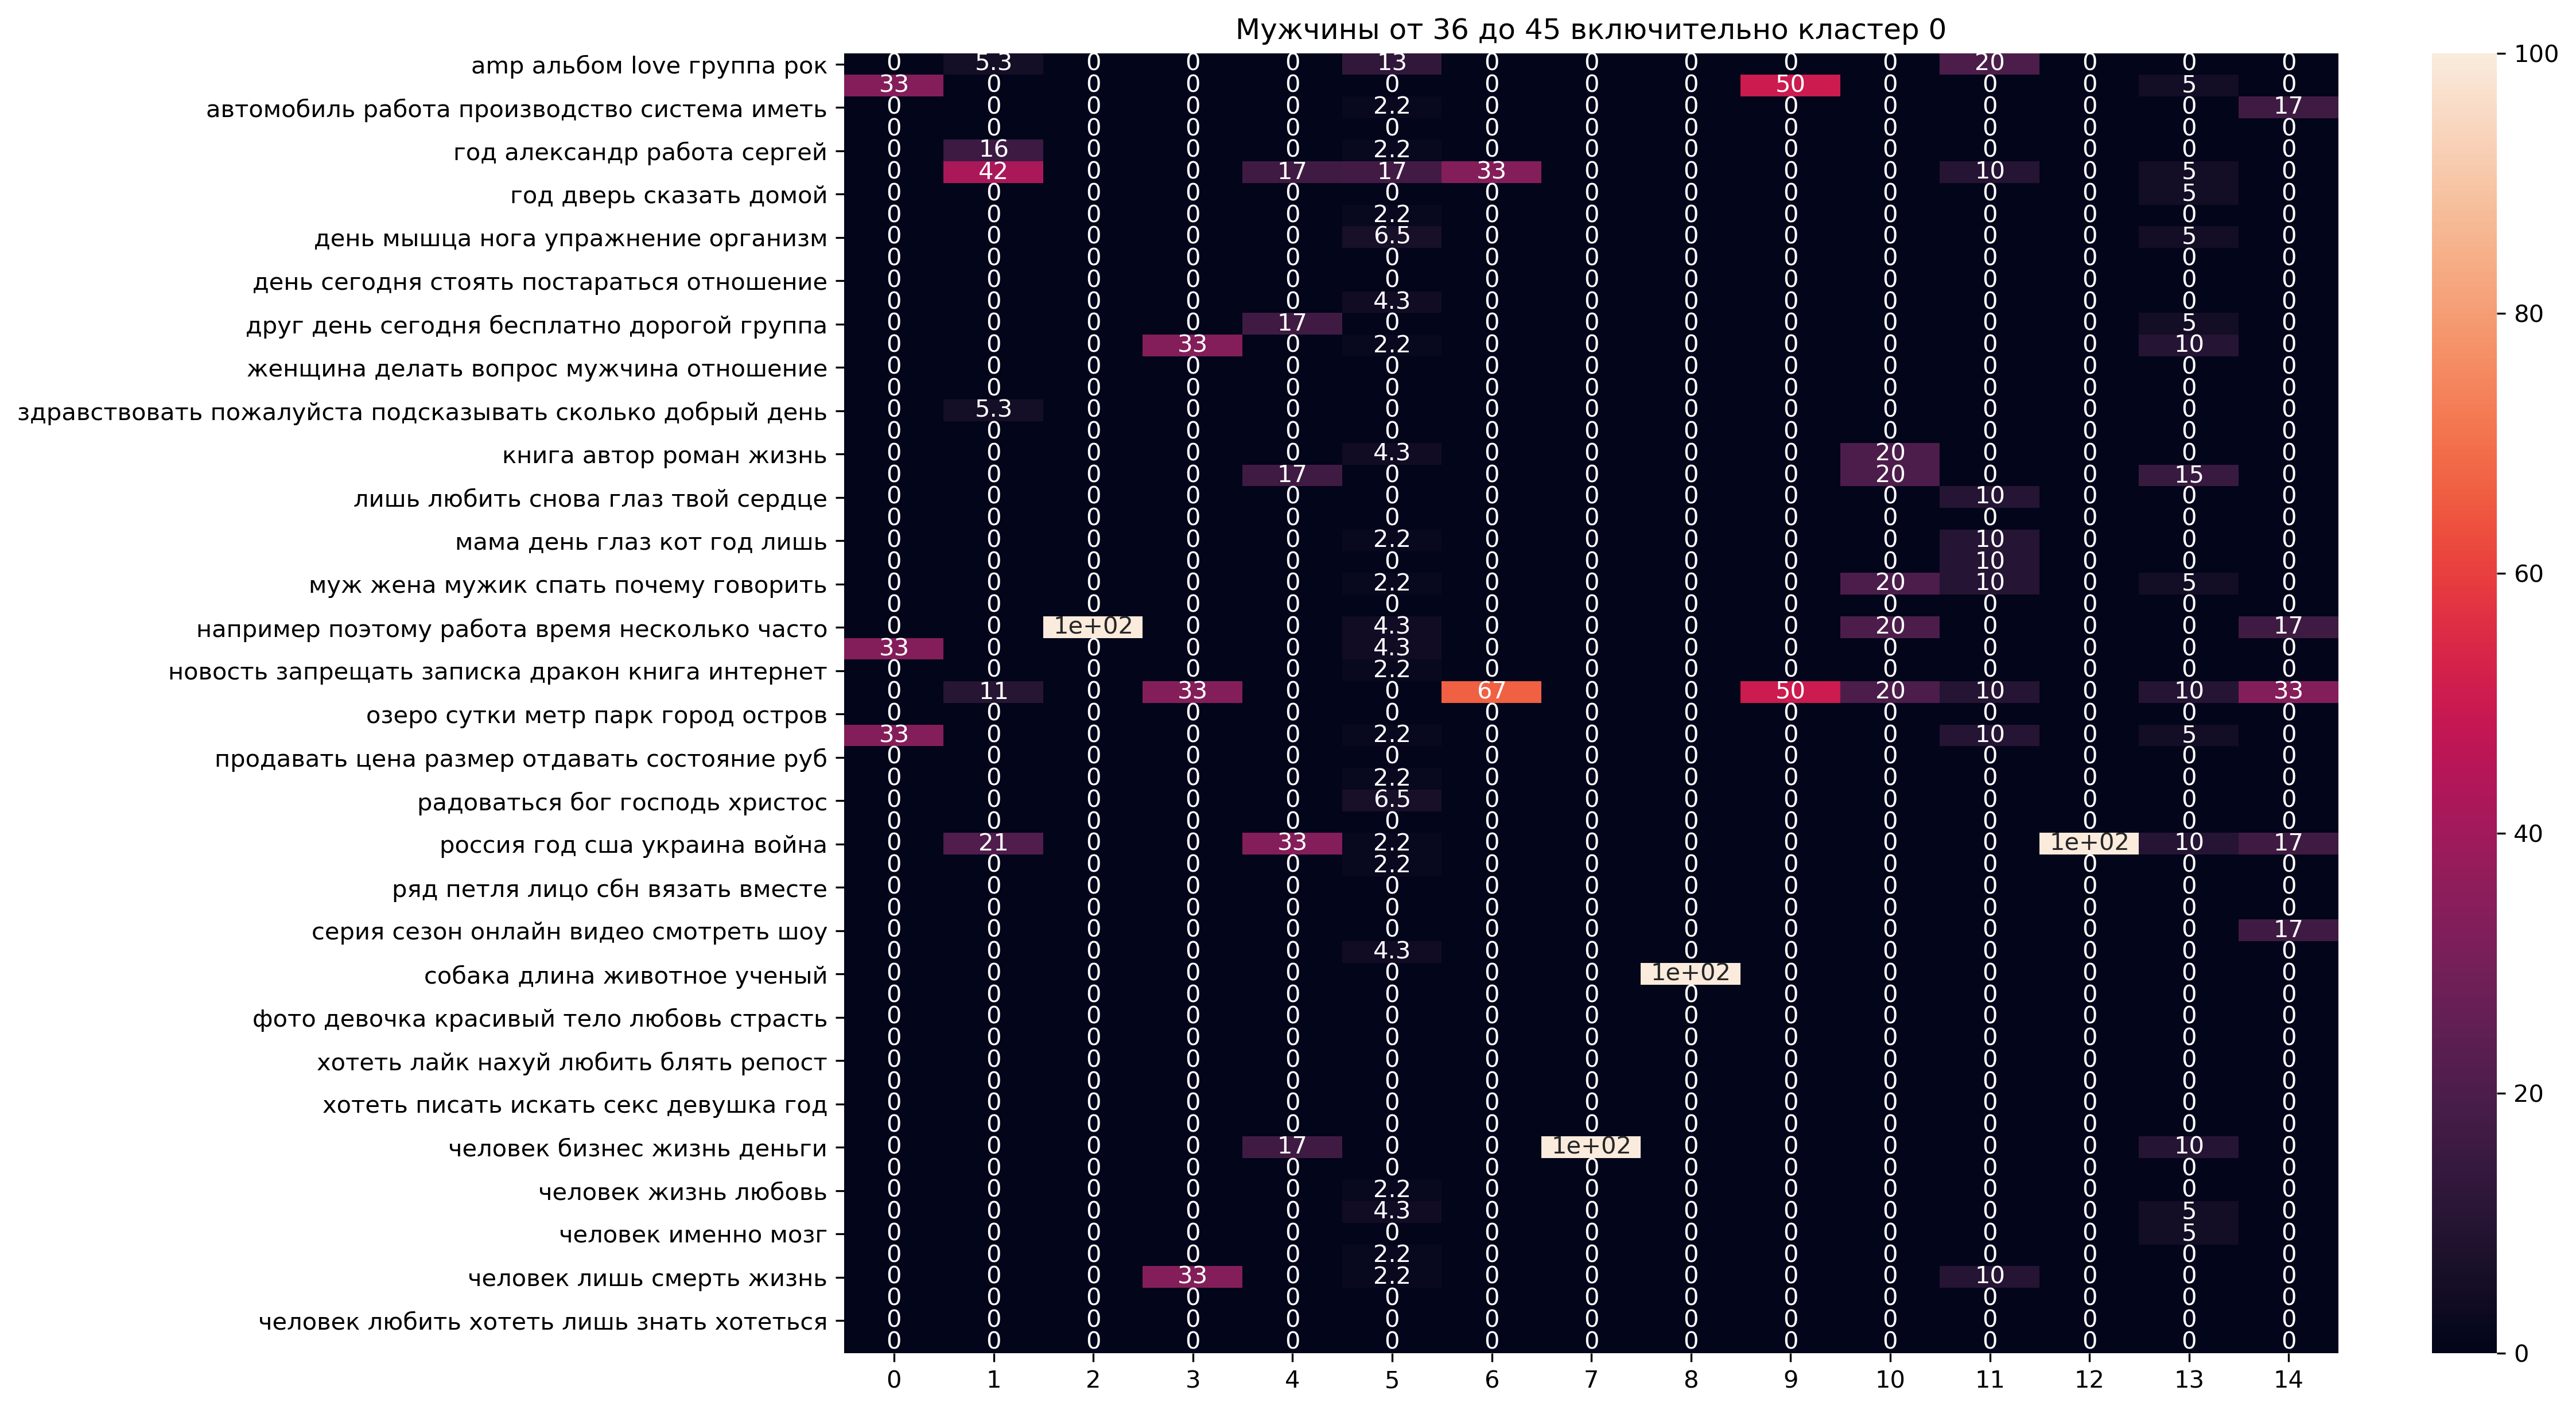

In [42]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 10), dpi=300)
a = grouping['(36.0, 45.0]_1'] \
                   .drop(columns = ['user','age','sex','age_group','count']) \
                   .loc[grouping['(36.0, 45.0]_1']['ag_lables'] == 0] \
                   .drop(columns = 'ag_lables') \
                   .iloc[:15,:]
ax = plt.axes()
ax.set_title('Мужчины от 36 до 45 включительно кластер 0')
sb.heatmap(a.T, annot = True)

## Мужчины от 20 до 27 включительно кластер 0

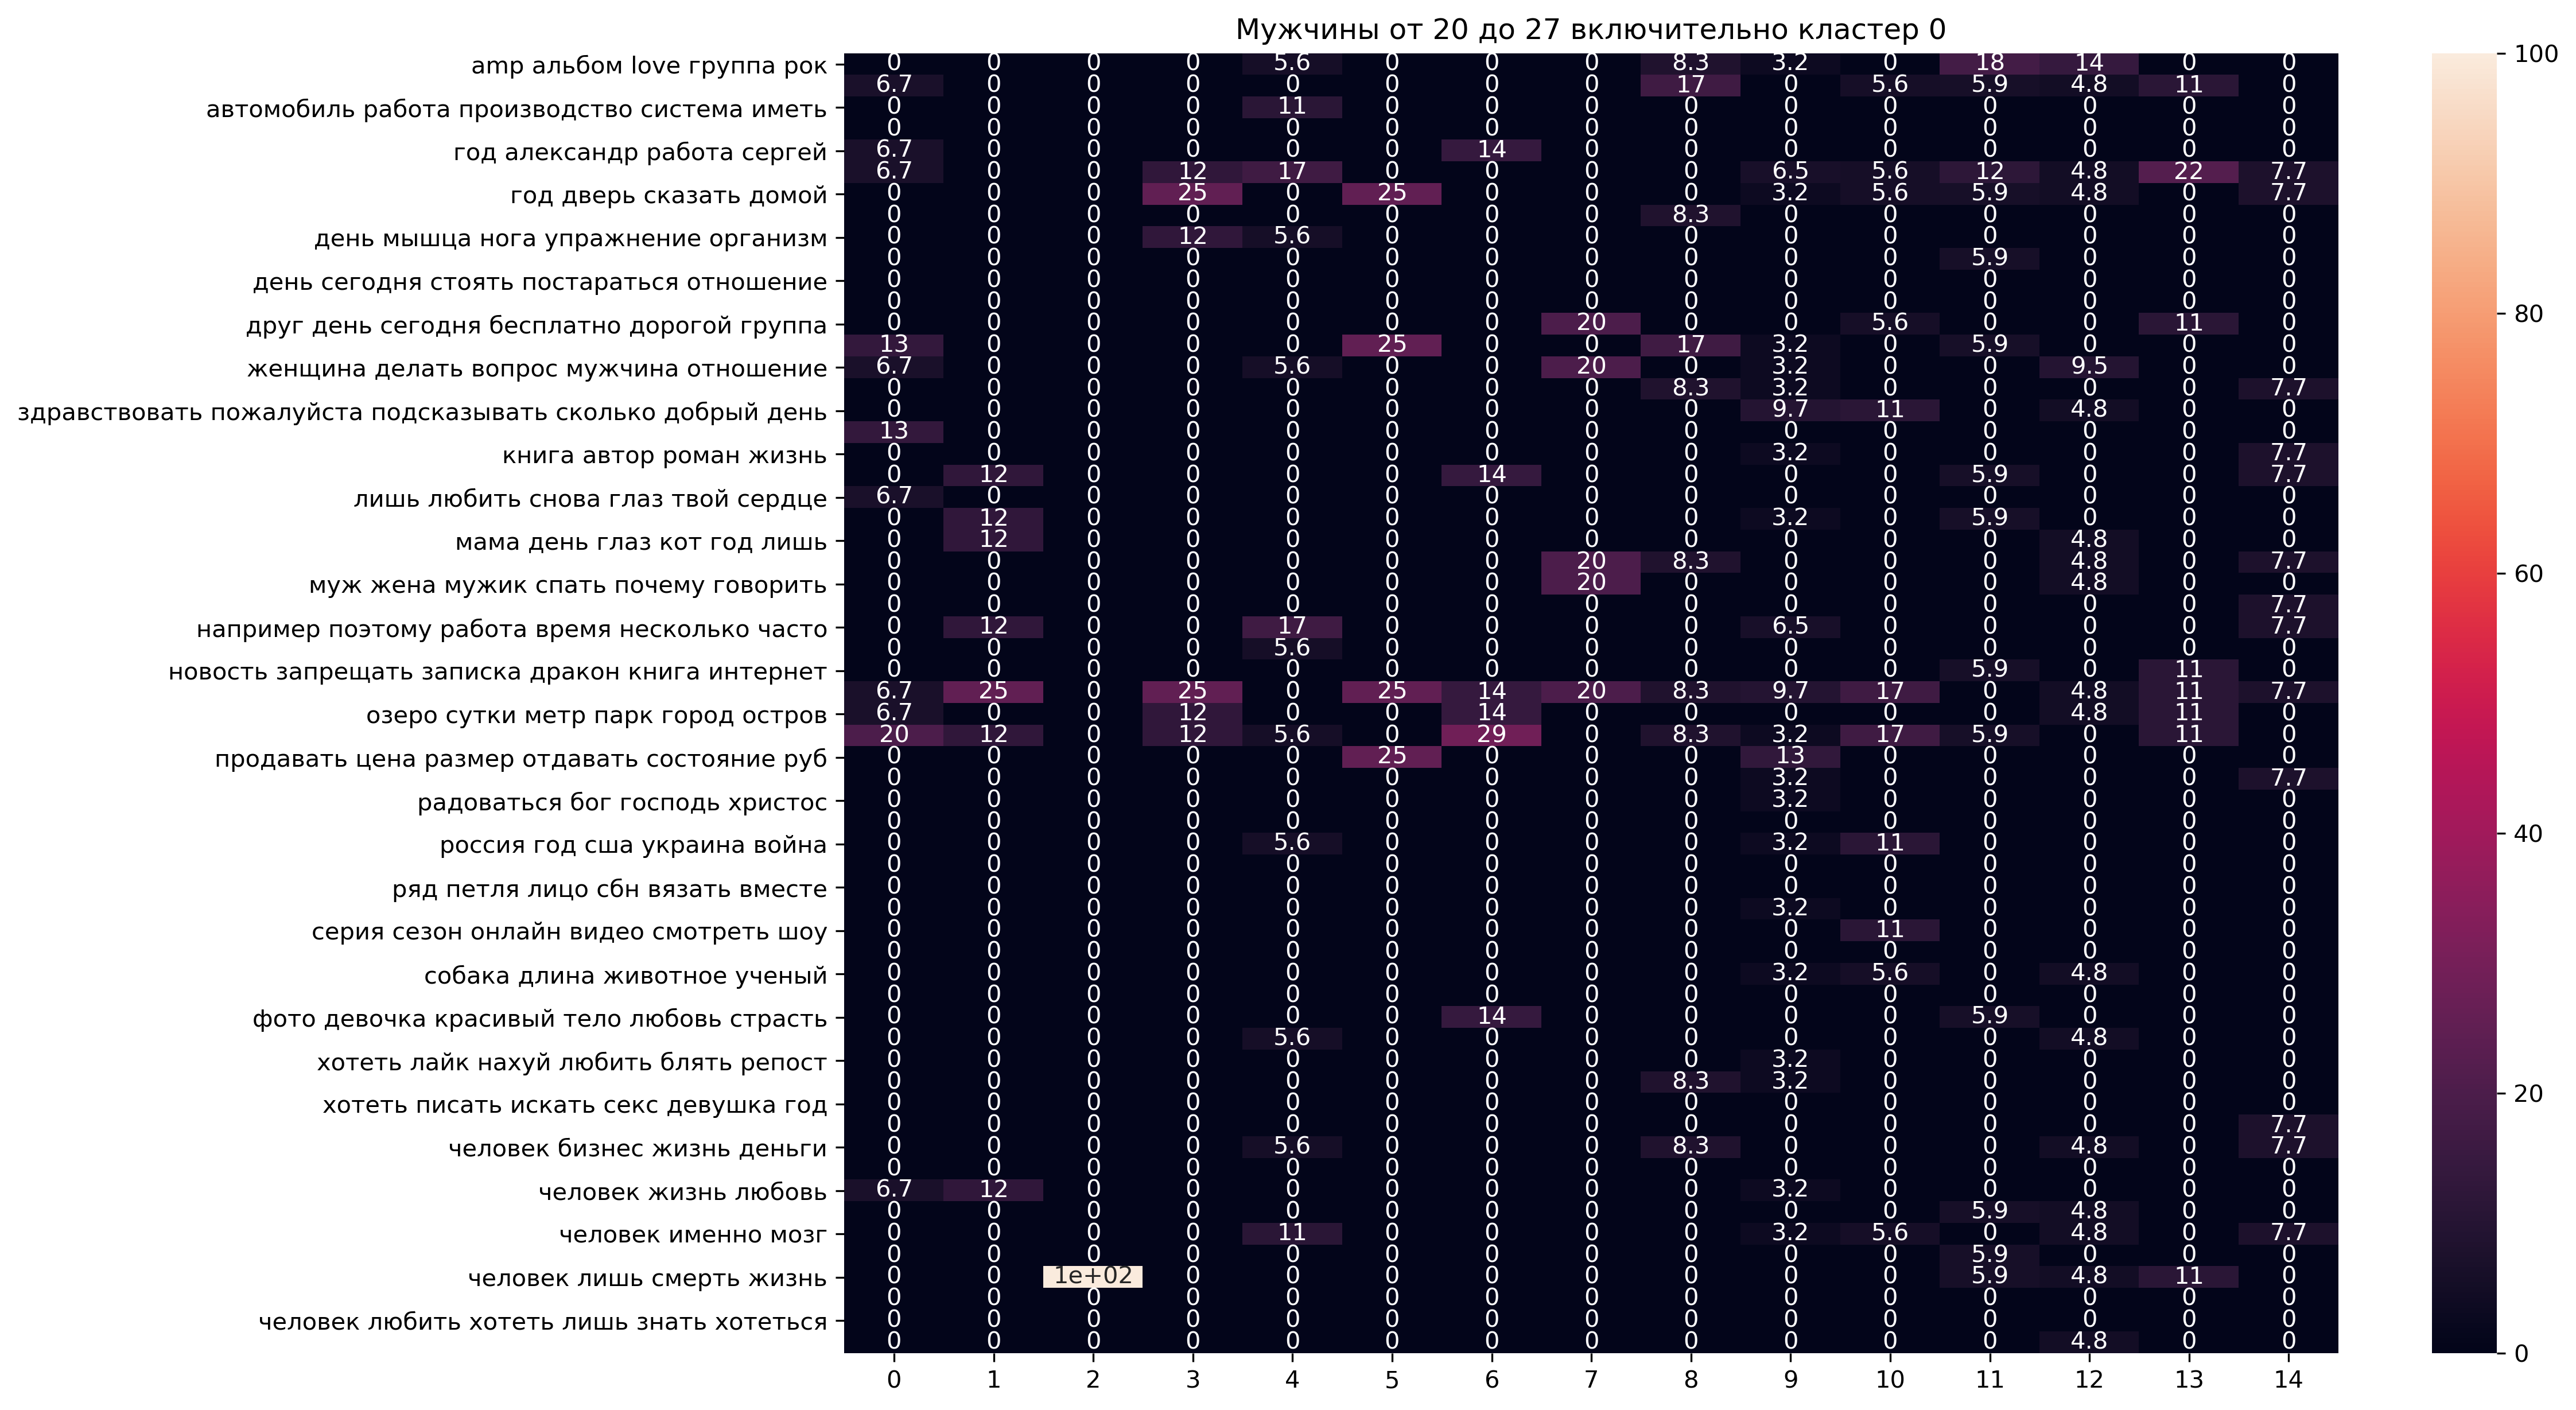

In [43]:
figure(num=None, figsize=(14, 10), dpi=300)

a = grouping['(20.0, 27.0]_1'] \
                   .drop(columns = ['user','age','sex','age_group','count']) \
                   .loc[grouping['(20.0, 27.0]_1']['ag_lables'] == 0] \
                   .drop(columns = 'ag_lables') \
                   .iloc[:15,:]
ax = plt.axes()
ax.set_title('Мужчины от 20 до 27 включительно кластер 0')
sb.heatmap(a.T, annot = True)

## Женщины от 27 до 36 включительно кластер 0

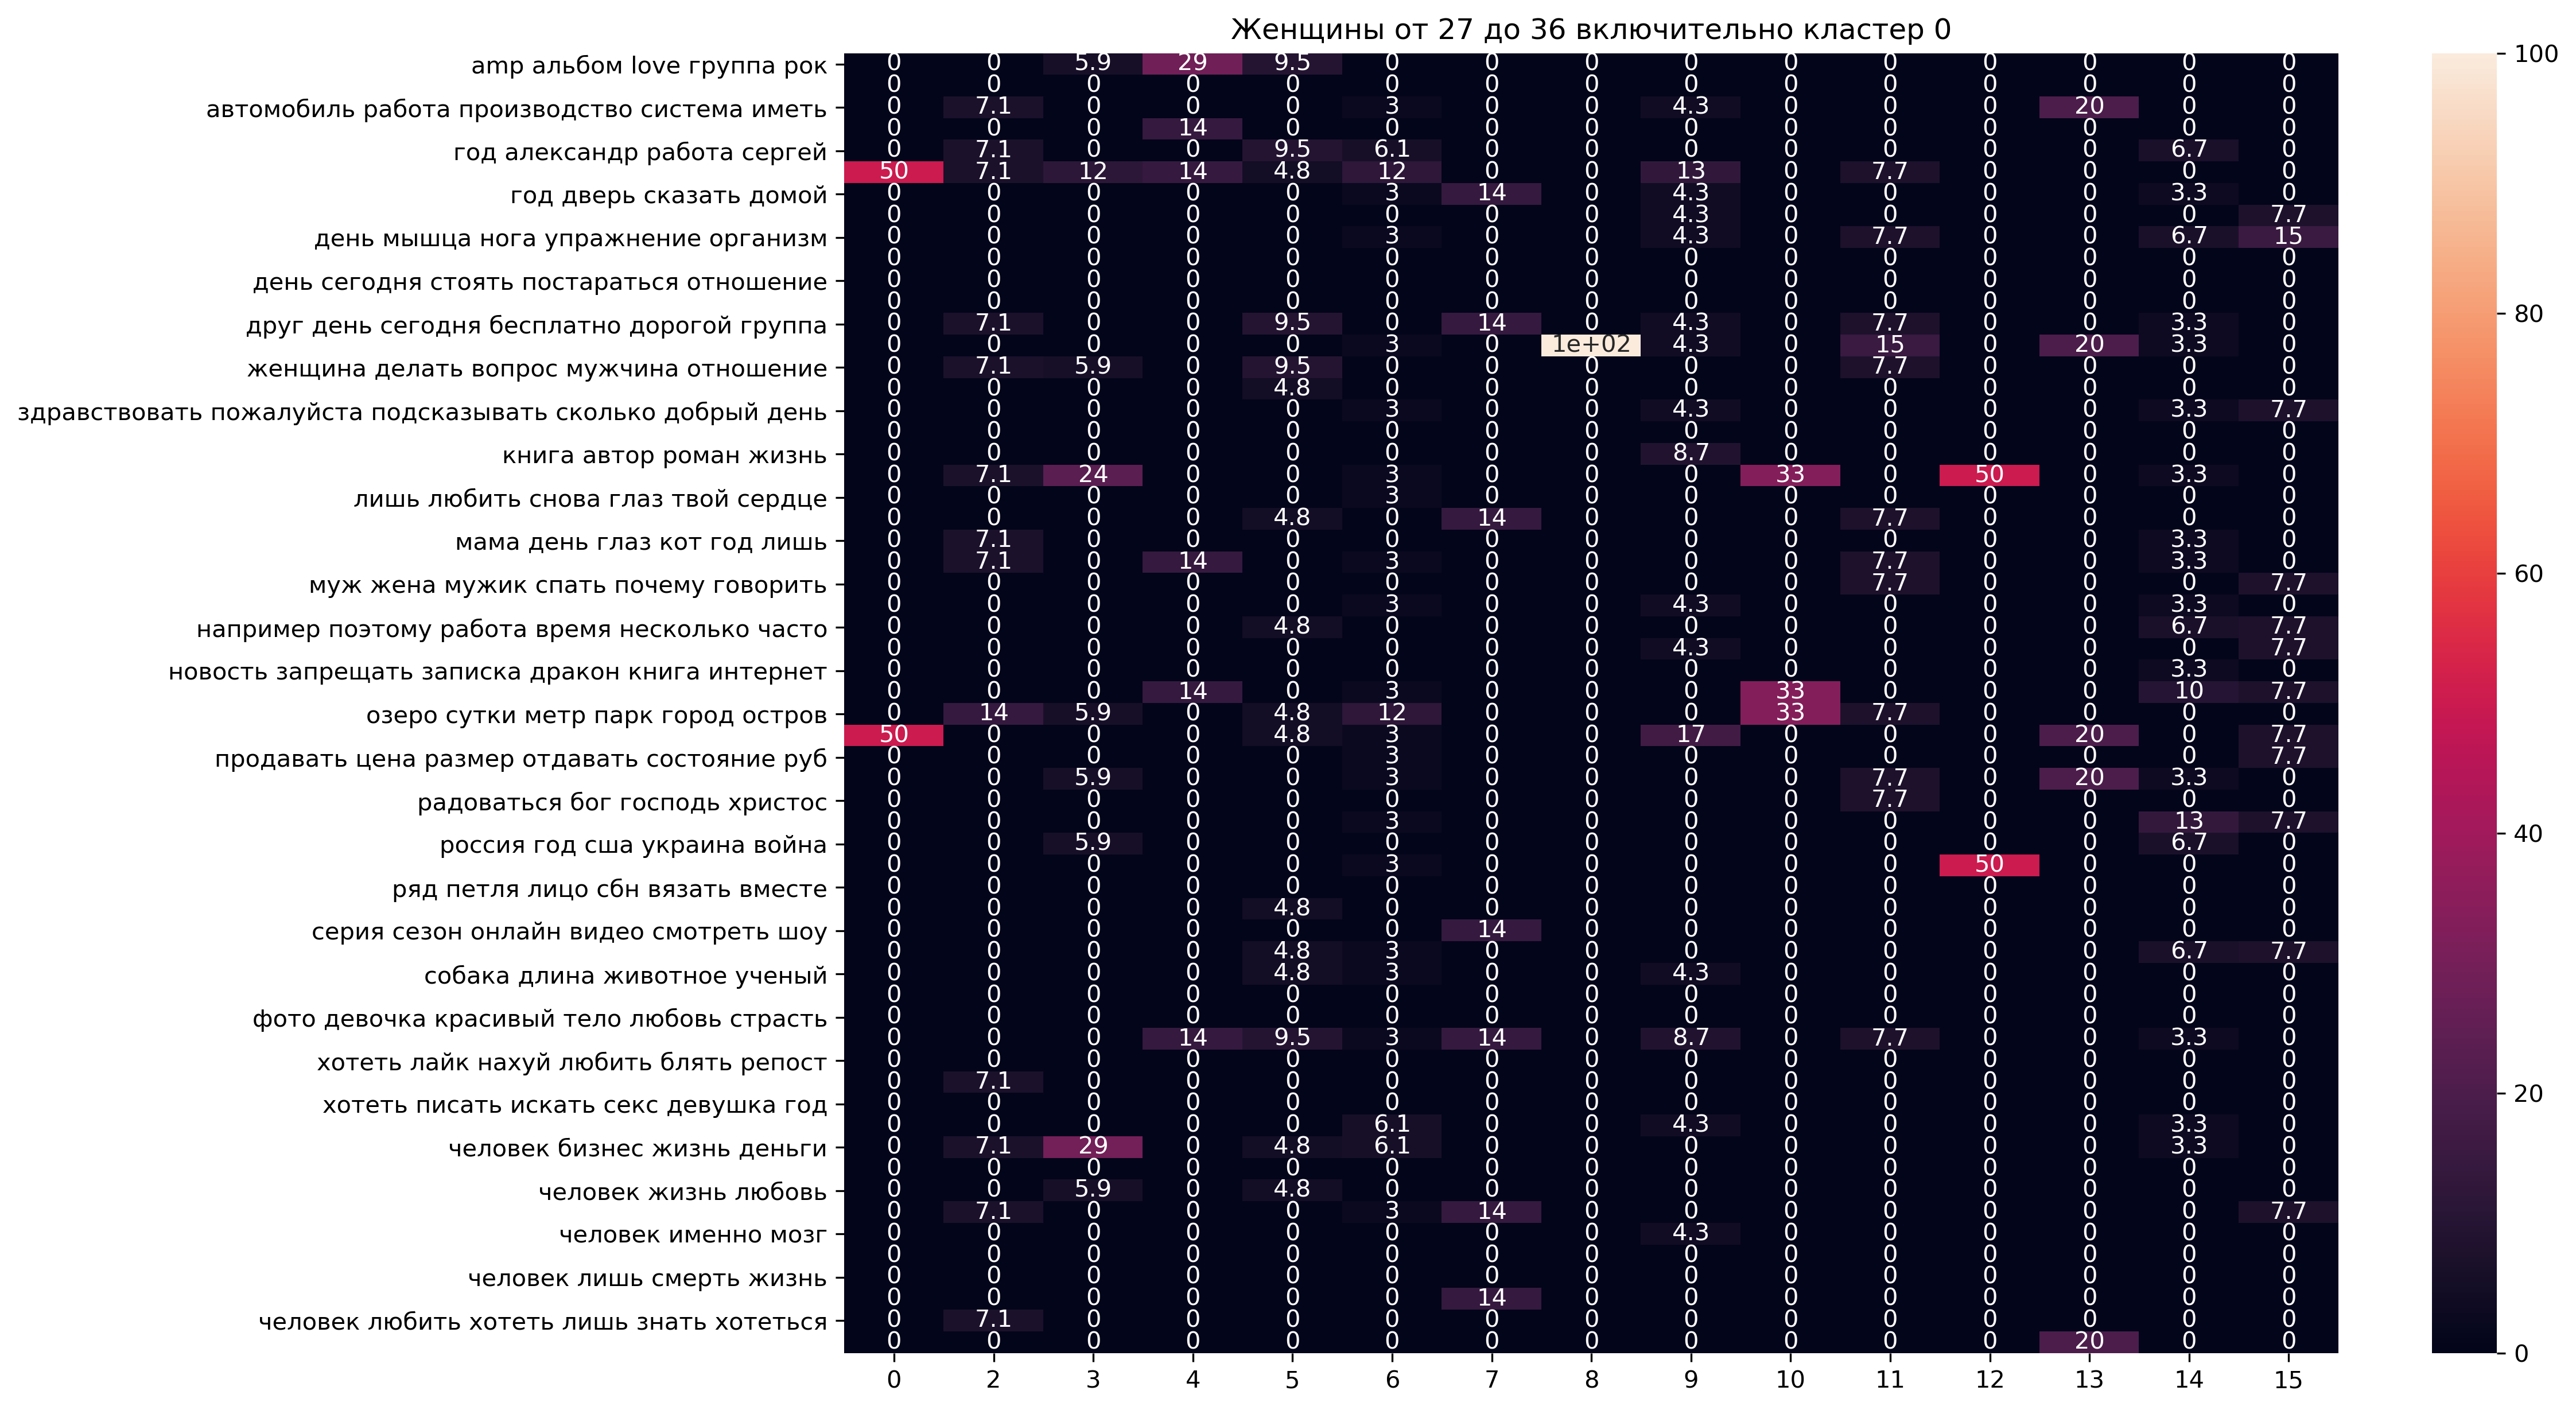

In [44]:
figure(num=None, figsize=(14, 10), dpi=300)
a = grouping['(27.0, 36.0]_0'] \
                    .drop(columns = ['user','age','sex','age_group','count']) \
                   .loc[grouping['(27.0, 36.0]_0']['ag_lables'] == 0] \
                   .drop(columns = 'ag_lables') \
                   .iloc[:15,:]
ax = plt.axes()
ax.set_title('Женщины от 27 до 36 включительно кластер 0')
sb.heatmap(a.T, annot = True)

In [45]:
grouping.pop('(0.0, 14.0]_0')
grouping.pop('(0.0, 14.0]_1')
grouping.pop('nan_0')
grouping.pop('nan_1')



user  age  sex age_group  count  amp альбом love группа рок  \
0           175    0    1       nan      1                    0.000000   
1          1139    0    1       nan      1                    0.000000   
2          2023    0    1       nan      1                    0.000000   
3          2611    0    1       nan      1                    0.000000   
4          3427    0    1       nan      1                   20.000000   
5          4023    0    1       nan      1                    0.000000   
6          5338    0    1       nan      1                    3.658537   
7          7930    0    1       nan      1                    0.000000   
8          8112    0    1       nan      1                    0.000000   
9          8153    0    1       nan      1                   33.333333   
10         8356    0    1       nan      1                    0.000000   
11         9587    0    1       nan      1                    0.000000   
12        13090    0    1       nan      1                   15.384615   
13        21553    0    1       nan      1                    0.000000   
14        24155    0    1       nan      1                  100.000000   
15        24255    0    1       nan      1                    0.000000   
16        24486    0    1       nan      1                    0.000000   
17        25644    0    1       nan      1                    0.000000   
18        30421    0    1       nan      1                    0.000000   
19        31656    0    1       nan      1                    0.000000   
20        32018    0    1       nan      1                    0.000000   
21        37971    0    1       nan      1                    0.000000   
22        38413    0    1       nan      1                   25.000000   
23        41485    0    1       nan      1                    0.000000   
24        42961    0    1       nan      1                    0.000000   
25        43826    0    1       nan      1                    0.000000   
26        49790    0    1       nan      1                    6.250000   
27        51005    0    1       nan      1                   11.111111   
28        54853    0    1       nan      1                    0.000000   
29        56473    0    1       nan      1                    0.000000   
...         ...  ...  ...       ...    ...                         ...   
3096  391176410    0    1       nan      1                    0.000000   
3097  391240855    0    1       nan      1                    0.000000   
3098  391272754    0    1       nan      1                    0.000000   
3099  391626608    0    1       nan      1                    0.000000   
3100  391757587    0    1       nan      1                    0.000000   
3101  393189291    0    1       nan      1                    0.000000   
3102  394916277    0    1       nan      1                    0.000000   
3103  395379355    0    1       nan      1                    0.000000   
3104  396326776    0    1       nan      1                    0.000000   
3105  397524298    0    1       nan      1                    0.000000   
3106  397817621    0    1       nan      1                    0.000000   
3107  400515367    0    1       nan      1                    0.000000   
3108  403991303    0    1       nan      1                    0.000000   
3109  405842463    0    1       nan      1                    0.000000   
3110  408451873    0    1       nan      1                    0.000000   
3111  410457778    0    1       nan      1                    0.000000   
3112  412728331    0    1       nan      1                    0.000000   
3113  414534212    0    1       nan      1                    0.000000   
3114  415702094    0    1       nan      1                    0.000000   
3115  416092694    0    1       nan      1                   16.666667   
3116  418755697    0    1       nan      1                    0.000000   
3117  424762841    0    1       nan      1                    0.000000   
3118  425434131

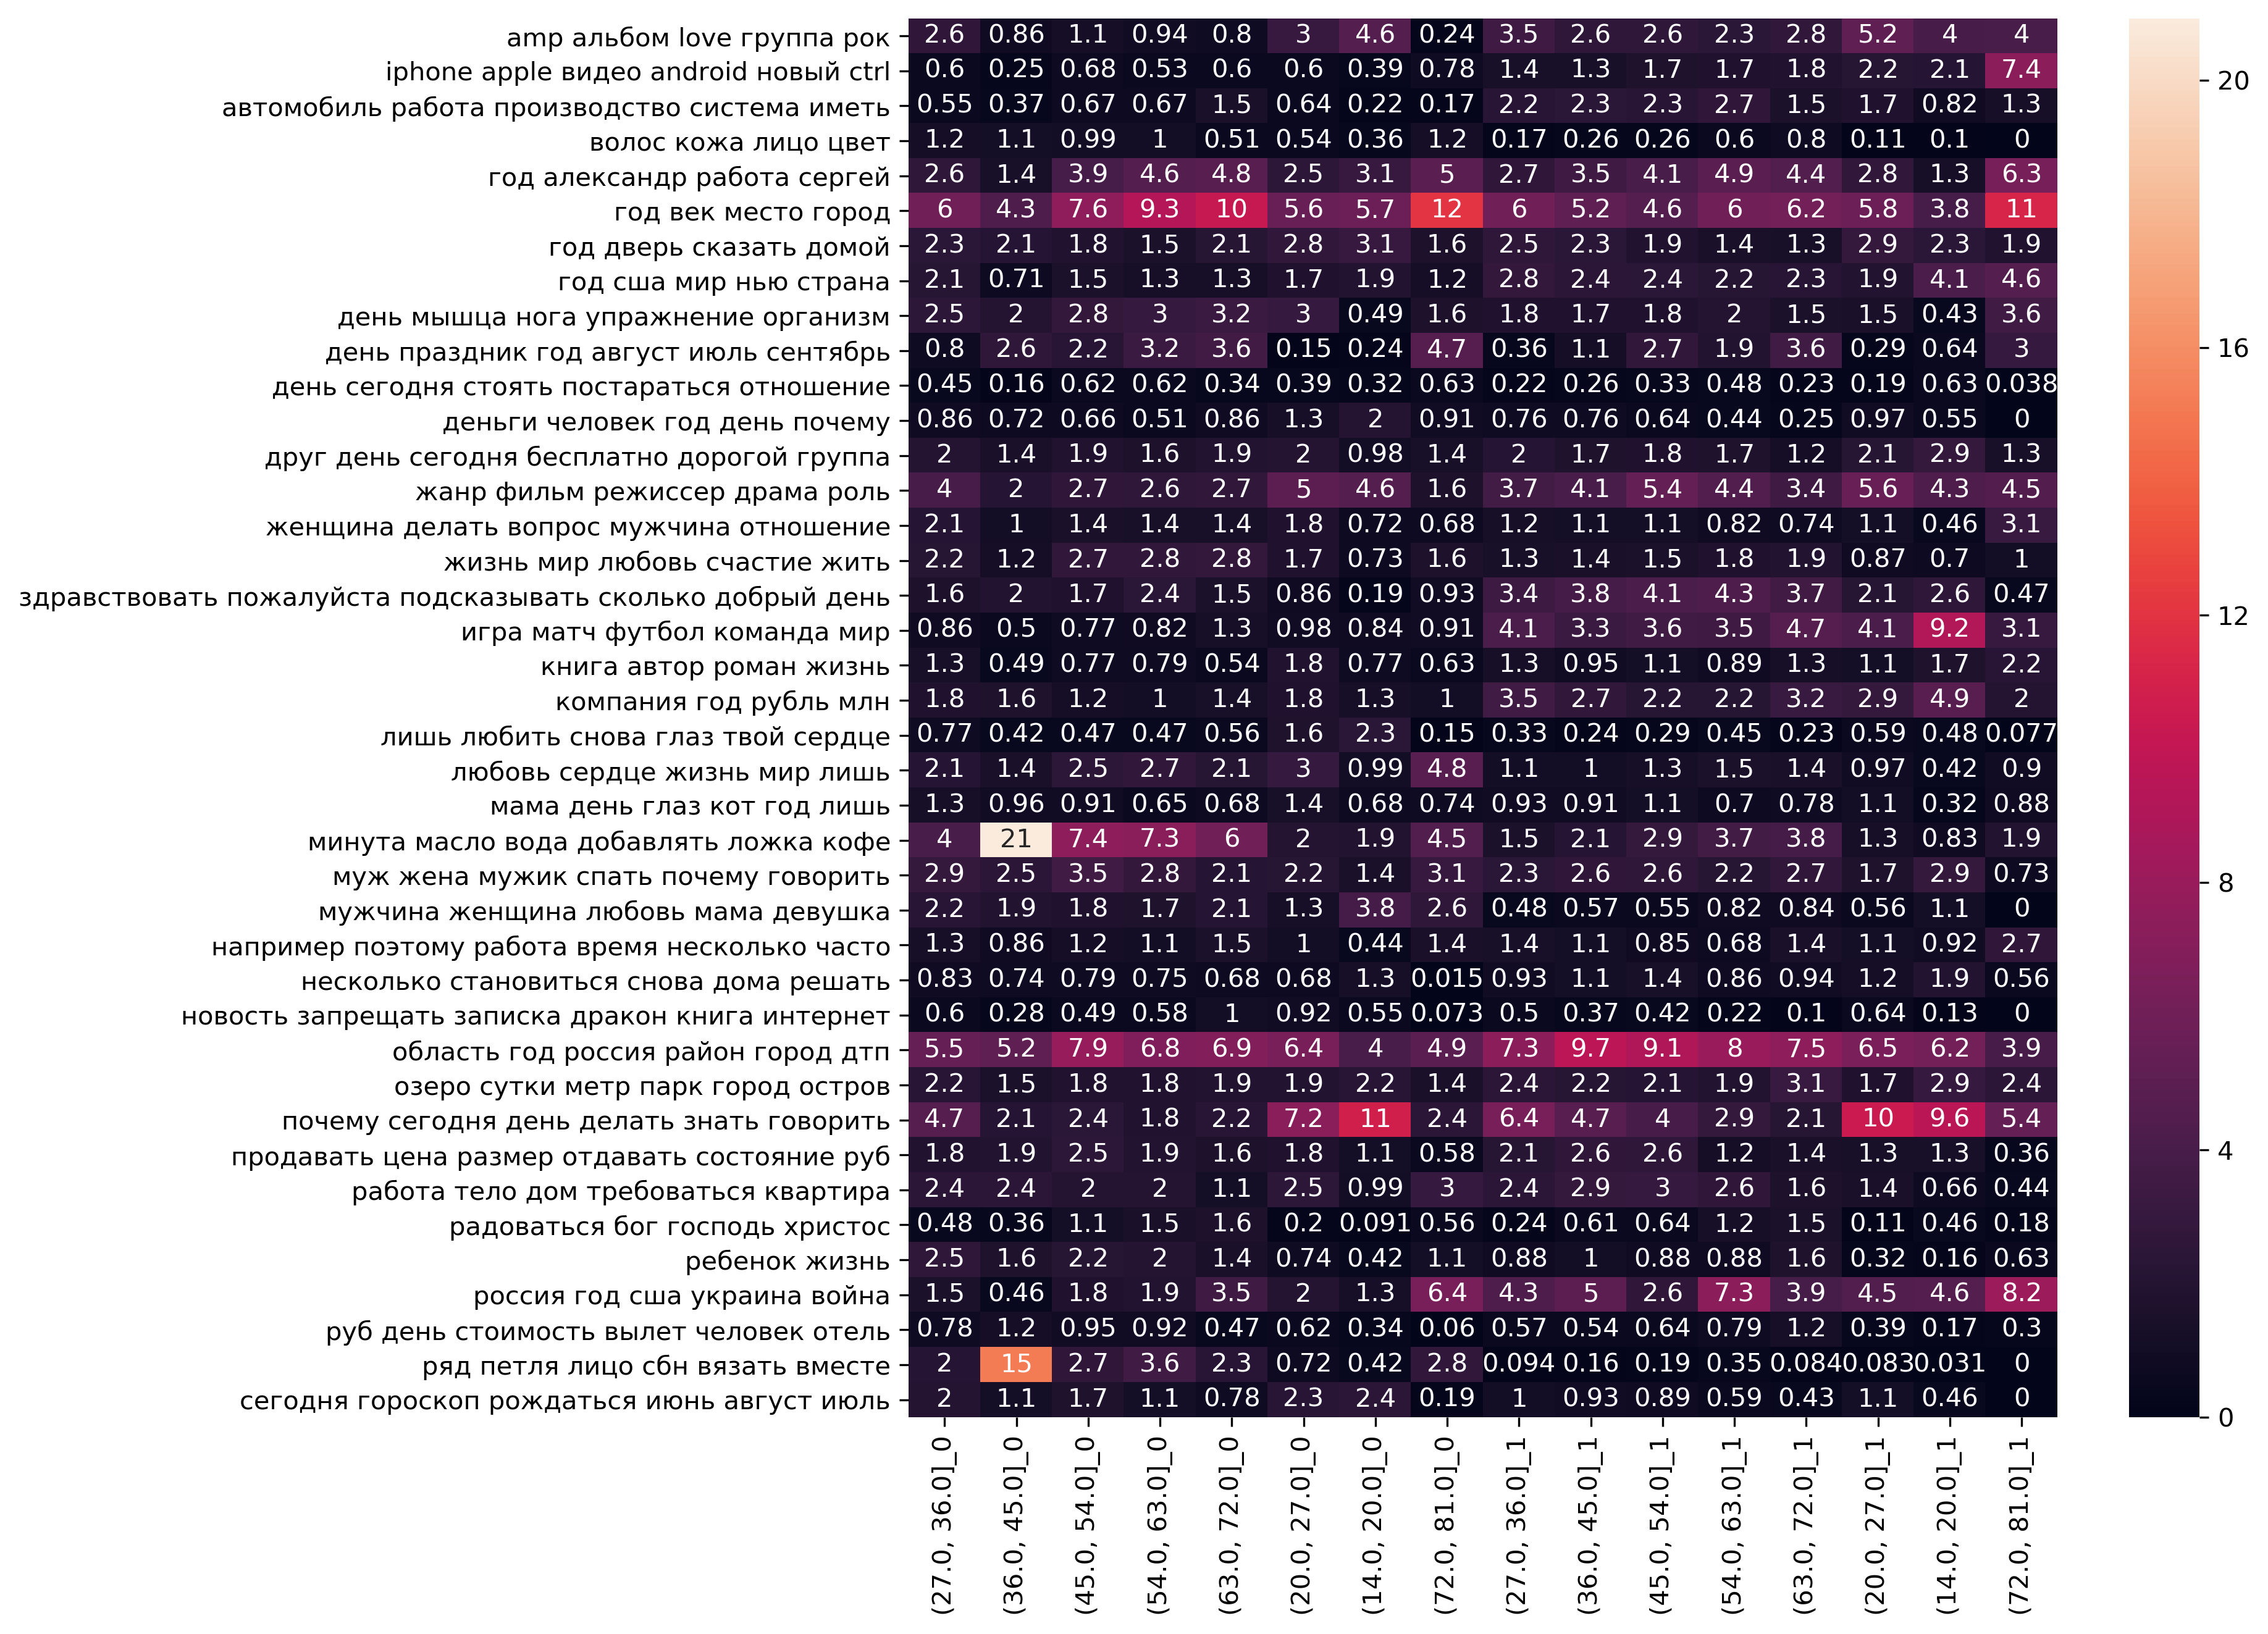

In [52]:
hm = pd.DataFrame()
for i in grouping:
    hm[i] =  grouping[i] \
                .drop(columns = ['user','age','sex','age_group','count']) \
                .loc[grouping[i]['ag_lables'] == 0] \
                .drop(columns = 'ag_lables') \
                .mean()


figure(num=None, figsize=(10, 10), dpi=300)
#hm.iloc[:40,:]
heat_map = sb.heatmap(hm.iloc[:40,:], annot=True)
plt.show(heat_map)

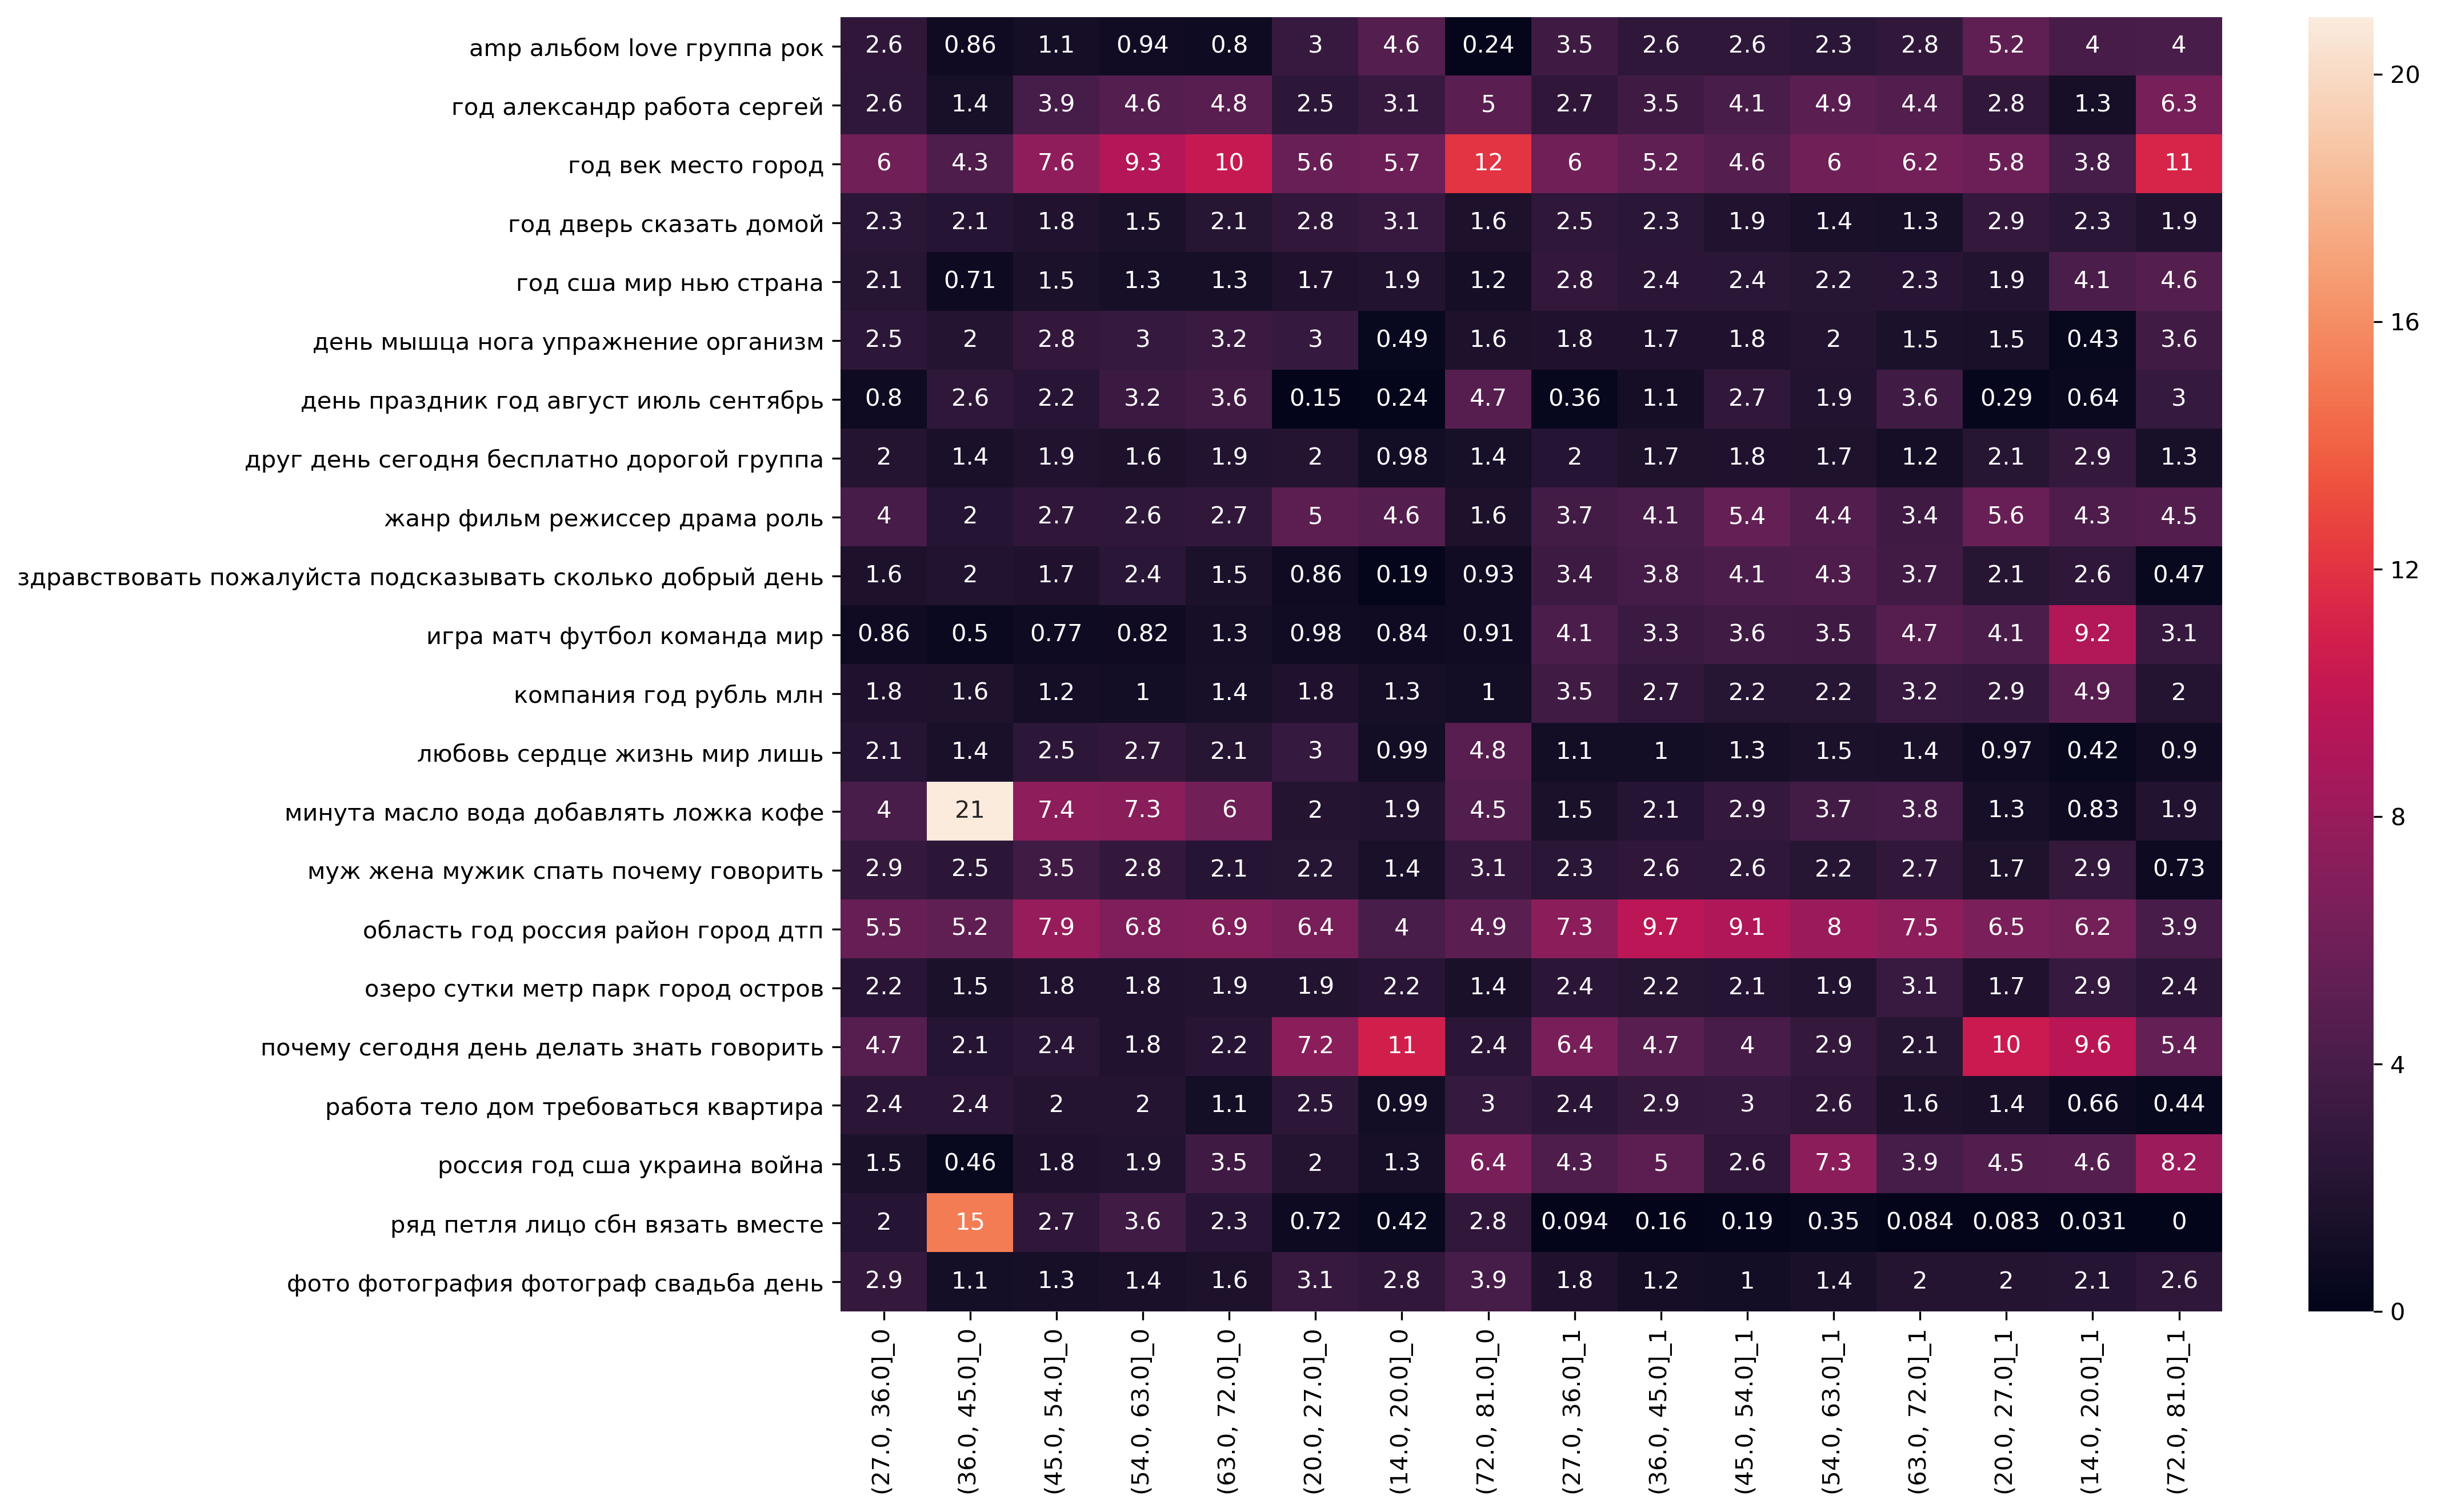

In [101]:
hm2 = hm
hm2['mean'] = list(hm2.T.mean())
hm2 = hm2[hm2['mean'] >1.7].drop(columns = 'mean')
figure(num=None, figsize=(13, 10), dpi=300)
heat_map = sb.heatmap(hm2, annot=True)
plt.show(heat_map)

/Users/apple/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4943f2128>,
      dtype=object)

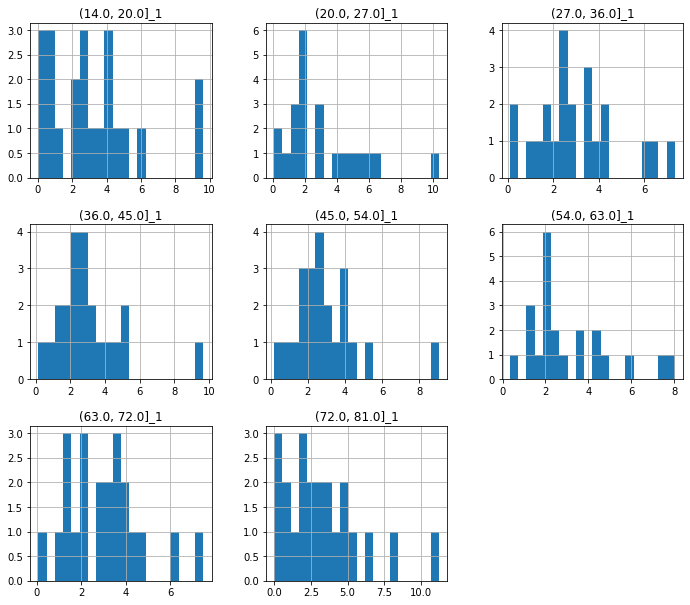

In [155]:

a4_dims = (11.7, 10.27)
fig, ax = plt.subplots(figsize=a4_dims)
#hm2.hist(bins=20,grid = True, ax=ax)
hm2.iloc[:,8:].hist(bins=20, ax=ax)

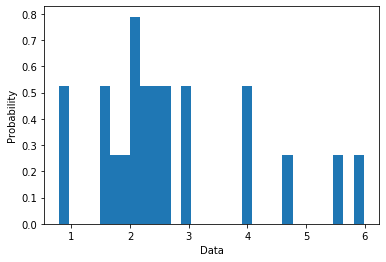

In [167]:
# '(27.0, 36.0]_0'
plt.hist(hm2['(27.0, 36.0]_0'], density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');
#plt.xticks(range(len(hm2['(27.0, 36.0]_0'])), hm2['(27.0, 36.0]_0'], size='small')
plt.show()

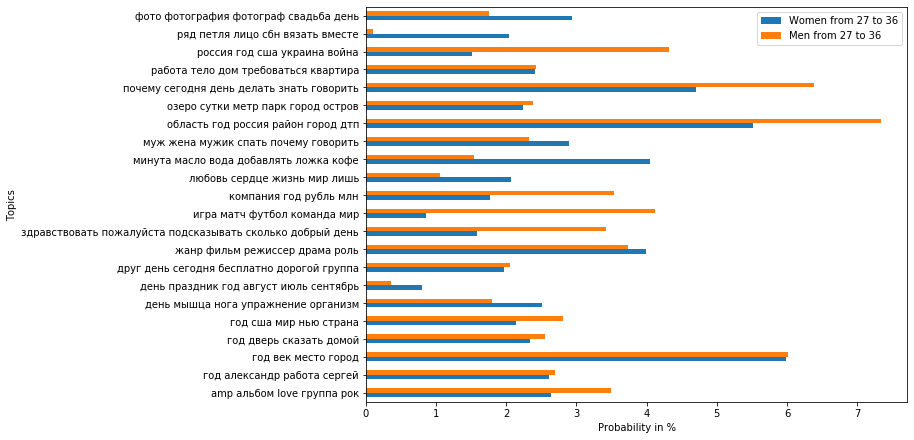

In [194]:
a4_dims = (9.7, 7.27)
fig, ax = plt.subplots(figsize=a4_dims)
hm2 \
    .rename(columns = {'(27.0, 36.0]_0':'Women from 27 to 36','(27.0, 36.0]_1':'Men from 27 to 36'}) \
    .loc[:,['Women from 27 to 36','Men from 27 to 36']] \
    .plot.barh(ax = ax)
#(kind = 'bar', ax = ax,subplots = False)

plt.ylabel('Topics')
plt.xlabel('Probability in %');


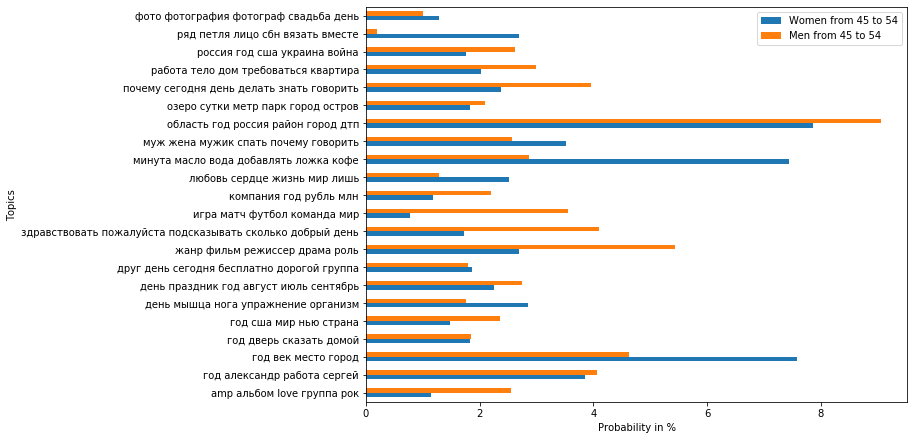

In [196]:
a4_dims = (9.7, 7.27)
fig, ax = plt.subplots(figsize=a4_dims)
hm2 \
    .rename(columns = {'(45.0, 54.0]_0':'Women from 45 to 54','(45.0, 54.0]_1':'Men from 45 to 54'}) \
    .loc[:,['Women from 45 to 54','Men from 45 to 54']] \
    .plot.barh(ax = ax)

plt.ylabel('Topics')
plt.xlabel('Probability in %');